In [1]:
import os
import gc
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:5


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
#reading test data in .R format
# a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
# a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

In [5]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [6]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [7]:
# 5.250.000, 10.080.000
# len(raw_train), len(raw_test)

> ### Train-test-split

In [8]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [9]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1
# raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1

In [10]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [11]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [12]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)
# X_test = raw_test.drop('index', axis=1)

> ### Scaling

In [13]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])
# X_test[features] = scaler.transform(X_test[features])

> ### Dataset and dataloader

In [14]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [15]:
# s_list = [0, 100, 200, 300, 400] #len = 5
# l_list = [1, 5, 10, 25, 50, 100] #len = 6


# for idx in range(239, 271): 

#     fault_sim_idx = idx // (len(s_list) * len(l_list))
    
#     start_length_idxs = idx % (len(s_list) * len(l_list))
    
#     print(fault_sim_idx, start_length_idxs)
#     start_idx = s_list[start_length_idxs // len(l_list)]
#     seq_length = l_list[start_length_idxs % len(l_list)]
#     print("start:", start_idx)
#     print("length:", seq_length)
    
#     X_train_tmp = X_train[X_train['index'] == fault_sim_idx].values[start_idx:start_idx+seq_length, :]
    
#     print(X_train_tmp.shape)

In [30]:
class DataTEP(Dataset):

    def __init__(self, X):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
#         self.s_list = [20, 100, 200, 300, 400]
        self.s_list = [300]
#         self.l_list = [1, 5, 10, 25, 50, 100]
#         self.l_list = [10, 50]
        self.l_list = [100]
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]
        
#         print(start_idx, start_idx+seq_length)

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [31]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [32]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [33]:
train_ds = DataTEP(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

# test_ds = DataTEP(X_test)
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [34]:
len(train_ds), len(val_ds)

(8400, 2100)

In [35]:
gc.collect()

7

> ### Model

In [36]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x

In [37]:
class UniModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm = nn.LSTM(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_lstm_out, _ = self.lstm(x_packed)
        
        x_unpacked, _ = pad_packed_sequence(x_lstm_out, batch_first=True)
        
        x = self.head(x_unpacked[:, -1])
        
        return x

In [38]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 256
LINEAR_SIZE = 128
BIDIRECTIONAL = True

In [53]:
model = UniModel(NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
                 LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, DEVICE=device)

# model = TwinModel(NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=[41, 11], HIDDEN_SIZE=HIDDEN_SIZE,
#                  LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, DEVICE=device)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

torch.manual_seed(42)

In [54]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
        print(type(X_batch), type(X_lengths), type(y_batch))
        print(len(X_batch), len(X_lengths), len(y_batch))
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
        print("y_batch_train.size()", y_batch.size())
        print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
64 64 64
y_batch_train.size() torch.Size([64])
y_pred_train.size() torch.Size([64, 21]) 



In [55]:
# !rm -r runs

> ### Training

In [56]:
# writer = SummaryWriter(comment=f'NL{NUM_LAYERS}_H{HIDDEN_SIZE}_L{LINEAR_SIZE}_B{BIDIRECTIONAL}_S{-100}')

writer = SummaryWriter(comment=f'vizualization')

In [58]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')
#     print(f'Epoch: {epoch}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for item in model.parameters():
            print(item.grad.mean())
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            

    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




tensor(-2.2227e-05, device='cuda:5')
tensor(-4.0504e-05, device='cuda:5')
tensor(-0.0027, device='cuda:5')
tensor(-0.0027, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(7.5789e-06, device='cuda:5')
tensor(0.0051, device='cuda:5')
tensor(0.0051, device='cuda:5')
tensor(-2.1792e-07, device='cuda:5')
tensor(4.8510e-06, device='cuda:5')
tensor(7.3672e-05, device='cuda:5')
tensor(7.3672e-05, device='cuda:5')
tensor(-7.5441e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.3729e-05, device='cuda:5')
tensor(0.0016, device='cuda:5')
tensor(-1.4893e-11, device='cuda:5')
tensor(-7.0958e-10, device='cuda:5')



epoch time: 25.810552835464478
mean loss train: 1.5431152491342455, mean loss val: 1.3561698012124925
accuracy train: 0.4583333333333333, accuracy val: 0.4980952380952381
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




tensor(-6.1874e-05, device='cuda:5')
tensor(1.0712e-05, device='cuda:5')
tensor(0.0060, device='cuda:5')
tensor(0.0060, device='cuda:5')
tensor(-1.9147e-05, device='cuda:5')
tensor(-2.3461e-07, device='cuda:5')
tensor(-9.3898e-05, device='cuda:5')
tensor(-9.3898e-05, device='cuda:5')
tensor(4.4319e-07, device='cuda:5')
tensor(-4.8794e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-3.2534e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(9.6623e-05, device='cuda:5')
tensor(9.6623e-05, device='cuda:5')
tensor(2.1090e-05, device='cuda:5')
tensor(0.0010, device='cuda:5')
tensor(5.9178e-09, device='cuda:5')
tensor(3.5479e-09, device='cuda:5')



epoch time: 26.48942255973816
mean loss train: 1.249798673221043, mean loss val: 0.9357929618018014
accuracy train: 0.550952380952381, accuracy val: 0.6714285714285714
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




tensor(0.0001, device='cuda:5')
tensor(1.0665e-05, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-2.0168e-05, device='cuda:5')
tensor(7.4736e-07, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(-3.2117e-07, device='cuda:5')
tensor(1.3548e-06, device='cuda:5')
tensor(2.0418e-05, device='cuda:5')
tensor(2.0418e-05, device='cuda:5')
tensor(1.6944e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(4.7055e-05, device='cuda:5')
tensor(4.7055e-05, device='cuda:5')
tensor(2.7711e-05, device='cuda:5')
tensor(0.0019, device='cuda:5')
tensor(-1.3388e-09, device='cuda:5')
tensor(-3.0157e-09, device='cuda:5')



epoch time: 25.97634983062744
mean loss train: 0.8439759817577543, mean loss val: 0.6763085132730858
accuracy train: 0.6788095238095239, accuracy val: 0.74
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




tensor(-3.8148e-05, device='cuda:5')
tensor(-5.4199e-06, device='cuda:5')
tensor(-0.0009, device='cuda:5')
tensor(-0.0009, device='cuda:5')
tensor(3.6311e-05, device='cuda:5')
tensor(1.4352e-07, device='cuda:5')
tensor(-8.0370e-05, device='cuda:5')
tensor(-8.0370e-05, device='cuda:5')
tensor(7.8189e-07, device='cuda:5')
tensor(-1.4969e-07, device='cuda:5')
tensor(-3.6041e-05, device='cuda:5')
tensor(-3.6041e-05, device='cuda:5')
tensor(-2.7457e-06, device='cuda:5')
tensor(0., device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(1.7650e-05, device='cuda:5')
tensor(0.0011, device='cuda:5')
tensor(-2.1082e-09, device='cuda:5')
tensor(-1.9513e-09, device='cuda:5')



epoch time: 27.006897926330566
mean loss train: 0.663127323332287, mean loss val: 0.6161997857530203
accuracy train: 0.729047619047619, accuracy val: 0.7476190476190476
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




tensor(1.0360e-05, device='cuda:5')
tensor(-1.2776e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(1.8571e-06, device='cuda:5')
tensor(1.1609e-07, device='cuda:5')
tensor(-2.0967e-05, device='cuda:5')
tensor(-2.0967e-05, device='cuda:5')
tensor(-1.3534e-07, device='cuda:5')
tensor(-6.1263e-07, device='cuda:5')
tensor(2.4259e-06, device='cuda:5')
tensor(2.4259e-06, device='cuda:5')
tensor(1.0760e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.5583e-06, device='cuda:5')
tensor(-6.5583e-06, device='cuda:5')
tensor(-2.4398e-06, device='cuda:5')
tensor(-4.9785e-05, device='cuda:5')
tensor(-4.3237e-09, device='cuda:5')
tensor(-4.0801e-09, device='cuda:5')



epoch time: 25.819099187850952
mean loss train: 0.6819541998136611, mean loss val: 0.4739405735262803
accuracy train: 0.7305952380952381, accuracy val: 0.7985714285714286
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




tensor(5.4955e-07, device='cuda:5')
tensor(-9.9568e-07, device='cuda:5')
tensor(-4.5729e-05, device='cuda:5')
tensor(-4.5729e-05, device='cuda:5')
tensor(-7.3257e-07, device='cuda:5')
tensor(-1.0338e-07, device='cuda:5')
tensor(7.4991e-07, device='cuda:5')
tensor(7.4991e-07, device='cuda:5')
tensor(-5.9236e-08, device='cuda:5')
tensor(-1.4037e-07, device='cuda:5')
tensor(-9.7325e-07, device='cuda:5')
tensor(-9.7325e-07, device='cuda:5')
tensor(-4.0805e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.4371e-06, device='cuda:5')
tensor(-6.4371e-06, device='cuda:5')
tensor(-1.7184e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.3079e-09, device='cuda:5')
tensor(4.6566e-10, device='cuda:5')



epoch time: 25.919177770614624
mean loss train: 0.4481913833958762, mean loss val: 0.44841029394284954
accuracy train: 0.7967857142857143, accuracy val: 0.7885714285714286
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




tensor(1.4466e-05, device='cuda:5')
tensor(9.6267e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(-1.4490e-05, device='cuda:5')
tensor(-1.4420e-07, device='cuda:5')
tensor(-7.0127e-05, device='cuda:5')
tensor(-7.0127e-05, device='cuda:5')
tensor(-9.8494e-08, device='cuda:5')
tensor(-3.9860e-07, device='cuda:5')
tensor(3.0679e-05, device='cuda:5')
tensor(3.0679e-05, device='cuda:5')
tensor(1.7440e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.0215e-05, device='cuda:5')
tensor(-6.0215e-05, device='cuda:5')
tensor(-1.7120e-05, device='cuda:5')
tensor(-0.0007, device='cuda:5')
tensor(-1.6429e-09, device='cuda:5')
tensor(-1.9513e-09, device='cuda:5')



epoch time: 26.041329383850098
mean loss train: 0.4708738495054699, mean loss val: 0.4055929065877128
accuracy train: 0.7884523809523809, accuracy val: 0.8042857142857143
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




tensor(9.1816e-06, device='cuda:5')
tensor(7.2579e-06, device='cuda:5')
tensor(0.0013, device='cuda:5')
tensor(0.0013, device='cuda:5')
tensor(2.0810e-06, device='cuda:5')
tensor(-7.2966e-08, device='cuda:5')
tensor(-9.2288e-05, device='cuda:5')
tensor(-9.2288e-05, device='cuda:5')
tensor(3.7720e-07, device='cuda:5')
tensor(1.9498e-06, device='cuda:5')
tensor(9.9592e-05, device='cuda:5')
tensor(9.9592e-05, device='cuda:5')
tensor(-5.7949e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.8140e-05, device='cuda:5')
tensor(-6.8140e-05, device='cuda:5')
tensor(6.4912e-06, device='cuda:5')
tensor(0.0008, device='cuda:5')
tensor(-3.0902e-10, device='cuda:5')
tensor(7.0958e-10, device='cuda:5')



epoch time: 26.775516986846924
mean loss train: 0.40590980132420856, mean loss val: 0.4276818442344319
accuracy train: 0.8048809523809524, accuracy val: 0.8057142857142857
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




tensor(1.0870e-07, device='cuda:5')
tensor(2.4889e-09, device='cuda:5')
tensor(-1.0921e-05, device='cuda:5')
tensor(-1.0921e-05, device='cuda:5')
tensor(-1.1710e-06, device='cuda:5')
tensor(-6.7060e-08, device='cuda:5')
tensor(2.0194e-05, device='cuda:5')
tensor(2.0194e-05, device='cuda:5')
tensor(-7.1749e-10, device='cuda:5')
tensor(-3.0780e-07, device='cuda:5')
tensor(-2.5779e-05, device='cuda:5')
tensor(-2.5779e-05, device='cuda:5')
tensor(-1.5258e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-7.6781e-06, device='cuda:5')
tensor(-7.6781e-06, device='cuda:5')
tensor(-6.7931e-07, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-1.4110e-09, device='cuda:5')
tensor(-1.4192e-09, device='cuda:5')



epoch time: 26.314732313156128
mean loss train: 0.4375185067313058, mean loss val: 0.37690598304073014
accuracy train: 0.7933333333333333, accuracy val: 0.8071428571428572
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




tensor(-5.2862e-06, device='cuda:5')
tensor(5.0962e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(-2.6503e-08, device='cuda:5')
tensor(-1.4804e-07, device='cuda:5')
tensor(-1.2422e-06, device='cuda:5')
tensor(-1.2422e-06, device='cuda:5')
tensor(-2.0422e-09, device='cuda:5')
tensor(-2.0972e-07, device='cuda:5')
tensor(-1.9962e-05, device='cuda:5')
tensor(-1.9962e-05, device='cuda:5')
tensor(-4.3259e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.2758e-06, device='cuda:5')
tensor(-3.2758e-06, device='cuda:5')
tensor(-1.0265e-06, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(4.3601e-09, device='cuda:5')
tensor(1.9513e-09, device='cuda:5')



epoch time: 26.049769639968872
mean loss train: 0.36121984192303247, mean loss val: 0.3650312455508503
accuracy train: 0.8152380952380952, accuracy val: 0.8142857142857143
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




tensor(-1.0910e-07, device='cuda:5')
tensor(3.6562e-08, device='cuda:5')
tensor(-3.3351e-05, device='cuda:5')
tensor(-3.3351e-05, device='cuda:5')
tensor(-1.8765e-07, device='cuda:5')
tensor(-1.0039e-07, device='cuda:5')
tensor(-2.6469e-05, device='cuda:5')
tensor(-2.6469e-05, device='cuda:5')
tensor(-8.8566e-08, device='cuda:5')
tensor(-4.0684e-07, device='cuda:5')
tensor(-1.9753e-05, device='cuda:5')
tensor(-1.9753e-05, device='cuda:5')
tensor(-4.9660e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.1586e-05, device='cuda:5')
tensor(-2.1586e-05, device='cuda:5')
tensor(-2.1831e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-7.4592e-09, device='cuda:5')
tensor(-5.8540e-09, device='cuda:5')



epoch time: 26.161510467529297
mean loss train: 0.3778057182970501, mean loss val: 0.34892668042886293
accuracy train: 0.8102380952380952, accuracy val: 0.8247619047619048
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




tensor(1.2915e-05, device='cuda:5')
tensor(-2.8382e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(7.0342e-06, device='cuda:5')
tensor(-6.7788e-08, device='cuda:5')
tensor(4.7383e-05, device='cuda:5')
tensor(4.7383e-05, device='cuda:5')
tensor(-1.0237e-07, device='cuda:5')
tensor(-1.8176e-08, device='cuda:5')
tensor(-1.7383e-05, device='cuda:5')
tensor(-1.7383e-05, device='cuda:5')
tensor(2.1479e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.8786e-05, device='cuda:5')
tensor(-1.8786e-05, device='cuda:5')
tensor(-3.5567e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(5.7559e-09, device='cuda:5')
tensor(3.8583e-09, device='cuda:5')



epoch time: 26.789434909820557
mean loss train: 0.3578510636375064, mean loss val: 0.3596014815286201
accuracy train: 0.8238095238095238, accuracy val: 0.8238095238095238
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




tensor(6.9959e-06, device='cuda:5')
tensor(-5.4662e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(3.6450e-06, device='cuda:5')
tensor(2.0384e-07, device='cuda:5')
tensor(4.9437e-05, device='cuda:5')
tensor(4.9437e-05, device='cuda:5')
tensor(-1.2636e-07, device='cuda:5')
tensor(4.4830e-07, device='cuda:5')
tensor(8.1858e-06, device='cuda:5')
tensor(8.1858e-06, device='cuda:5')
tensor(1.1377e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(3.6548e-05, device='cuda:5')
tensor(3.6548e-05, device='cuda:5')
tensor(6.6783e-07, device='cuda:5')
tensor(2.4294e-05, device='cuda:5')
tensor(4.5988e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 26.096448183059692
mean loss train: 0.34381994508561636, mean loss val: 0.38291043168050237
accuracy train: 0.8288095238095238, accuracy val: 0.8114285714285714
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




tensor(-1.2112e-05, device='cuda:5')
tensor(9.7853e-07, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(1.5308e-06, device='cuda:5')
tensor(-5.0226e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-8.4593e-08, device='cuda:5')
tensor(-7.9759e-08, device='cuda:5')
tensor(1.1690e-06, device='cuda:5')
tensor(1.1690e-06, device='cuda:5')
tensor(1.2100e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.2001e-05, device='cuda:5')
tensor(1.2001e-05, device='cuda:5')
tensor(3.2086e-07, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(1.8045e-09, device='cuda:5')
tensor(7.9828e-10, device='cuda:5')



epoch time: 26.22738766670227
mean loss train: 0.35518791255496796, mean loss val: 0.38069110052948374
accuracy train: 0.8219047619047619, accuracy val: 0.809047619047619
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




tensor(7.3007e-05, device='cuda:5')
tensor(1.4782e-06, device='cuda:5')
tensor(-0.0022, device='cuda:5')
tensor(-0.0022, device='cuda:5')
tensor(-1.3374e-06, device='cuda:5')
tensor(2.2077e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(4.9519e-07, device='cuda:5')
tensor(1.0667e-05, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(-7.2987e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.0781e-05, device='cuda:5')
tensor(-2.0781e-05, device='cuda:5')
tensor(-1.1225e-05, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-4.3813e-09, device='cuda:5')
tensor(-2.3061e-09, device='cuda:5')



epoch time: 26.953917741775513
mean loss train: 0.3499682891936529, mean loss val: 0.34910234576068994
accuracy train: 0.8283333333333334, accuracy val: 0.8280952380952381
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




tensor(-8.8632e-07, device='cuda:5')
tensor(-3.0878e-07, device='cuda:5')
tensor(6.9351e-06, device='cuda:5')
tensor(6.9351e-06, device='cuda:5')
tensor(-6.5692e-07, device='cuda:5')
tensor(-2.2806e-07, device='cuda:5')
tensor(-4.9571e-05, device='cuda:5')
tensor(-4.9571e-05, device='cuda:5')
tensor(-1.1113e-08, device='cuda:5')
tensor(-8.1217e-07, device='cuda:5')
tensor(-2.7382e-05, device='cuda:5')
tensor(-2.7382e-05, device='cuda:5')
tensor(2.9276e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.6732e-06, device='cuda:5')
tensor(2.6732e-06, device='cuda:5')
tensor(-5.1111e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.8659e-09, device='cuda:5')
tensor(1.9513e-09, device='cuda:5')



epoch time: 25.887096166610718
mean loss train: 0.36232299086593445, mean loss val: 0.3420476933884701
accuracy train: 0.8207142857142857, accuracy val: 0.8228571428571428
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




tensor(0.0003, device='cuda:5')
tensor(-1.9549e-05, device='cuda:5')
tensor(-0.0025, device='cuda:5')
tensor(-0.0025, device='cuda:5')
tensor(1.1904e-05, device='cuda:5')
tensor(4.1266e-06, device='cuda:5')
tensor(-0.0007, device='cuda:5')
tensor(-0.0007, device='cuda:5')
tensor(-1.4628e-06, device='cuda:5')
tensor(-1.0396e-06, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-2.3226e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.8794e-05, device='cuda:5')
tensor(1.8794e-05, device='cuda:5')
tensor(-9.8920e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(-8.9448e-10, device='cuda:5')
tensor(-1.0644e-09, device='cuda:5')



epoch time: 26.69345211982727
mean loss train: 0.3295134929248265, mean loss val: 0.3266386924471174
accuracy train: 0.8282142857142857, accuracy val: 0.8328571428571429
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




tensor(-8.4853e-07, device='cuda:5')
tensor(-4.8402e-07, device='cuda:5')
tensor(-1.4827e-05, device='cuda:5')
tensor(-1.4827e-05, device='cuda:5')
tensor(-1.3653e-07, device='cuda:5')
tensor(-2.1590e-08, device='cuda:5')
tensor(-6.5295e-06, device='cuda:5')
tensor(-6.5295e-06, device='cuda:5')
tensor(-2.6784e-08, device='cuda:5')
tensor(1.6224e-07, device='cuda:5')
tensor(-4.2582e-06, device='cuda:5')
tensor(-4.2582e-06, device='cuda:5')
tensor(-5.6016e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.1415e-05, device='cuda:5')
tensor(-1.1415e-05, device='cuda:5')
tensor(-8.9452e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(1.0093e-08, device='cuda:5')
tensor(6.6080e-09, device='cuda:5')



epoch time: 25.639041662216187
mean loss train: 0.3387790656657446, mean loss val: 0.3398198600042434
accuracy train: 0.8298809523809524, accuracy val: 0.8295238095238096
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




tensor(9.2835e-07, device='cuda:5')
tensor(4.6658e-09, device='cuda:5')
tensor(-1.9163e-05, device='cuda:5')
tensor(-1.9163e-05, device='cuda:5')
tensor(8.5815e-07, device='cuda:5')
tensor(2.0500e-09, device='cuda:5')
tensor(-4.4795e-06, device='cuda:5')
tensor(-4.4795e-06, device='cuda:5')
tensor(1.2471e-08, device='cuda:5')
tensor(1.6654e-07, device='cuda:5')
tensor(4.1284e-06, device='cuda:5')
tensor(4.1284e-06, device='cuda:5')
tensor(-1.0672e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.2379e-06, device='cuda:5')
tensor(-6.2379e-06, device='cuda:5')
tensor(-1.6324e-06, device='cuda:5')
tensor(-6.9361e-05, device='cuda:5')
tensor(4.5146e-09, device='cuda:5')
tensor(3.5479e-09, device='cuda:5')



epoch time: 25.882524728775024
mean loss train: 0.318406282606579, mean loss val: 0.3167350837163256
accuracy train: 0.8377380952380953, accuracy val: 0.8447619047619047
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




tensor(-1.8241e-05, device='cuda:5')
tensor(-2.2611e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-1.0523e-05, device='cuda:5')
tensor(-1.3479e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(1.2496e-06, device='cuda:5')
tensor(6.4917e-06, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(1.0652e-06, device='cuda:5')
tensor(0., device='cuda:5')
tensor(8.5027e-05, device='cuda:5')
tensor(8.5027e-05, device='cuda:5')
tensor(3.5082e-05, device='cuda:5')
tensor(0.0007, device='cuda:5')
tensor(4.1396e-09, device='cuda:5')
tensor(2.1287e-09, device='cuda:5')



epoch time: 26.118983030319214
mean loss train: 0.3014800889151437, mean loss val: 0.3166033143088931
accuracy train: 0.8497619047619047, accuracy val: 0.8428571428571429
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




tensor(-8.1063e-07, device='cuda:5')
tensor(4.5595e-08, device='cuda:5')
tensor(1.9832e-05, device='cuda:5')
tensor(1.9832e-05, device='cuda:5')
tensor(3.8797e-08, device='cuda:5')
tensor(-1.5227e-08, device='cuda:5')
tensor(1.4073e-06, device='cuda:5')
tensor(1.4073e-06, device='cuda:5')
tensor(1.2650e-09, device='cuda:5')
tensor(-1.3362e-07, device='cuda:5')
tensor(-6.6109e-06, device='cuda:5')
tensor(-6.6109e-06, device='cuda:5')
tensor(1.1378e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.7295e-07, device='cuda:5')
tensor(-4.7295e-07, device='cuda:5')
tensor(1.6549e-06, device='cuda:5')
tensor(7.1603e-05, device='cuda:5')
tensor(9.1646e-09, device='cuda:5')
tensor(5.3218e-09, device='cuda:5')



epoch time: 26.548217296600342
mean loss train: 0.2970134061291104, mean loss val: 0.3010254903067419
accuracy train: 0.846547619047619, accuracy val: 0.8447619047619047
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




tensor(-9.7547e-07, device='cuda:5')
tensor(1.4738e-07, device='cuda:5')
tensor(1.0767e-05, device='cuda:5')
tensor(1.0767e-05, device='cuda:5')
tensor(-2.0704e-07, device='cuda:5')
tensor(3.0852e-09, device='cuda:5')
tensor(1.4299e-06, device='cuda:5')
tensor(1.4299e-06, device='cuda:5')
tensor(1.9774e-08, device='cuda:5')
tensor(1.4273e-07, device='cuda:5')
tensor(2.0909e-06, device='cuda:5')
tensor(2.0909e-06, device='cuda:5')
tensor(3.1136e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(7.9605e-06, device='cuda:5')
tensor(7.9605e-06, device='cuda:5')
tensor(4.4374e-07, device='cuda:5')
tensor(6.4245e-06, device='cuda:5')
tensor(-1.3294e-10, device='cuda:5')
tensor(1.7739e-10, device='cuda:5')



epoch time: 26.235082149505615
mean loss train: 0.27768604721341816, mean loss val: 0.2869799713861236
accuracy train: 0.8572619047619048, accuracy val: 0.8447619047619047
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




tensor(-7.1598e-08, device='cuda:5')
tensor(2.0717e-08, device='cuda:5')
tensor(-7.5340e-06, device='cuda:5')
tensor(-7.5340e-06, device='cuda:5')
tensor(-1.4887e-07, device='cuda:5')
tensor(4.2593e-09, device='cuda:5')
tensor(5.2986e-06, device='cuda:5')
tensor(5.2986e-06, device='cuda:5')
tensor(-2.0354e-08, device='cuda:5')
tensor(-2.3440e-07, device='cuda:5')
tensor(-6.6984e-06, device='cuda:5')
tensor(-6.6984e-06, device='cuda:5')
tensor(5.8473e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.2092e-06, device='cuda:5')
tensor(2.2092e-06, device='cuda:5')
tensor(-9.9691e-07, device='cuda:5')
tensor(-5.8391e-05, device='cuda:5')
tensor(1.5056e-08, device='cuda:5')
tensor(1.0466e-08, device='cuda:5')



epoch time: 26.13886260986328
mean loss train: 0.27289782524108885, mean loss val: 0.28560538768764154
accuracy train: 0.8555952380952381, accuracy val: 0.8504761904761905
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




tensor(3.8166e-07, device='cuda:5')
tensor(-8.2175e-08, device='cuda:5')
tensor(-1.1122e-05, device='cuda:5')
tensor(-1.1122e-05, device='cuda:5')
tensor(1.2155e-07, device='cuda:5')
tensor(1.5125e-09, device='cuda:5')
tensor(-2.6012e-06, device='cuda:5')
tensor(-2.6012e-06, device='cuda:5')
tensor(1.5314e-09, device='cuda:5')
tensor(-7.7224e-08, device='cuda:5')
tensor(-3.8201e-06, device='cuda:5')
tensor(-3.8201e-06, device='cuda:5')
tensor(-5.3575e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.2705e-06, device='cuda:5')
tensor(-6.2705e-06, device='cuda:5')
tensor(-1.0476e-07, device='cuda:5')
tensor(-4.0795e-05, device='cuda:5')
tensor(8.9081e-09, device='cuda:5')
tensor(6.2975e-09, device='cuda:5')



epoch time: 26.742223024368286
mean loss train: 0.2825731489771888, mean loss val: 0.28433379059747194
accuracy train: 0.8582142857142857, accuracy val: 0.8442857142857143
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.0005




tensor(2.1874e-06, device='cuda:5')
tensor(-8.4044e-08, device='cuda:5')
tensor(-4.0745e-05, device='cuda:5')
tensor(-4.0745e-05, device='cuda:5')
tensor(4.7490e-07, device='cuda:5')
tensor(-1.4638e-08, device='cuda:5')
tensor(-1.0538e-05, device='cuda:5')
tensor(-1.0538e-05, device='cuda:5')
tensor(2.6371e-09, device='cuda:5')
tensor(1.3094e-07, device='cuda:5')
tensor(5.1756e-06, device='cuda:5')
tensor(5.1756e-06, device='cuda:5')
tensor(-1.3117e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.3970e-06, device='cuda:5')
tensor(-2.3970e-06, device='cuda:5')
tensor(-1.1060e-06, device='cuda:5')
tensor(-6.1222e-05, device='cuda:5')
tensor(9.2643e-09, device='cuda:5')
tensor(6.0758e-09, device='cuda:5')



epoch time: 27.05307364463806
mean loss train: 0.27233358848662603, mean loss val: 0.2839648287636841
accuracy train: 0.8588095238095238, accuracy val: 0.85
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.0005




tensor(3.2620e-07, device='cuda:5')
tensor(-3.1330e-08, device='cuda:5')
tensor(-9.4284e-06, device='cuda:5')
tensor(-9.4284e-06, device='cuda:5')
tensor(9.2351e-08, device='cuda:5')
tensor(4.7732e-09, device='cuda:5')
tensor(-4.5741e-06, device='cuda:5')
tensor(-4.5741e-06, device='cuda:5')
tensor(-1.3457e-08, device='cuda:5')
tensor(-1.0904e-07, device='cuda:5')
tensor(-4.1635e-06, device='cuda:5')
tensor(-4.1635e-06, device='cuda:5')
tensor(-5.3059e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-5.6224e-06, device='cuda:5')
tensor(-5.6224e-06, device='cuda:5')
tensor(-6.0435e-07, device='cuda:5')
tensor(-3.4120e-05, device='cuda:5')
tensor(2.8979e-10, device='cuda:5')
tensor(1.7739e-10, device='cuda:5')



epoch time: 26.978939533233643
mean loss train: 0.2649610640321459, mean loss val: 0.28204344953809984
accuracy train: 0.8623809523809524, accuracy val: 0.8528571428571429
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.0005




tensor(2.2904e-07, device='cuda:5')
tensor(3.1332e-08, device='cuda:5')
tensor(-2.7435e-06, device='cuda:5')
tensor(-2.7435e-06, device='cuda:5')
tensor(-1.9154e-07, device='cuda:5')
tensor(-1.2944e-08, device='cuda:5')
tensor(-4.1039e-06, device='cuda:5')
tensor(-4.1039e-06, device='cuda:5')
tensor(7.4897e-09, device='cuda:5')
tensor(-1.3484e-08, device='cuda:5')
tensor(-2.2940e-06, device='cuda:5')
tensor(-2.2940e-06, device='cuda:5')
tensor(-7.8296e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.5102e-06, device='cuda:5')
tensor(-1.5102e-06, device='cuda:5')
tensor(-2.4824e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(9.9385e-09, device='cuda:5')
tensor(6.4971e-09, device='cuda:5')



epoch time: 25.964707136154175
mean loss train: 0.2632079557577769, mean loss val: 0.2869503768285064
accuracy train: 0.8671428571428571, accuracy val: 0.8528571428571429
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.0005




tensor(-6.3266e-06, device='cuda:5')
tensor(-4.5742e-07, device='cuda:5')
tensor(2.0726e-05, device='cuda:5')
tensor(2.0726e-05, device='cuda:5')
tensor(-5.6175e-07, device='cuda:5')
tensor(2.6285e-08, device='cuda:5')
tensor(2.7408e-05, device='cuda:5')
tensor(2.7408e-05, device='cuda:5')
tensor(8.0248e-09, device='cuda:5')
tensor(3.3377e-07, device='cuda:5')
tensor(1.0208e-05, device='cuda:5')
tensor(1.0208e-05, device='cuda:5')
tensor(-1.5268e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.5897e-06, device='cuda:5')
tensor(-9.5897e-06, device='cuda:5')
tensor(9.1607e-09, device='cuda:5')
tensor(7.4864e-05, device='cuda:5')
tensor(-5.8871e-10, device='cuda:5')
tensor(-6.2088e-10, device='cuda:5')



epoch time: 25.61310887336731
mean loss train: 0.263397041502453, mean loss val: 0.2920152405330087
accuracy train: 0.8627380952380952, accuracy val: 0.8542857142857143
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.0005




tensor(-5.2955e-06, device='cuda:5')
tensor(5.9902e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(7.6301e-07, device='cuda:5')
tensor(2.0073e-08, device='cuda:5')
tensor(-2.4610e-05, device='cuda:5')
tensor(-2.4610e-05, device='cuda:5')
tensor(-1.9547e-07, device='cuda:5')
tensor(-3.3105e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-8.3665e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.5851e-05, device='cuda:5')
tensor(-2.5851e-05, device='cuda:5')
tensor(-7.4931e-06, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(8.7635e-09, device='cuda:5')
tensor(6.3862e-09, device='cuda:5')



epoch time: 26.252503871917725
mean loss train: 0.26417529338882084, mean loss val: 0.2886283327284331
accuracy train: 0.8645238095238095, accuracy val: 0.8528571428571429
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.0005




tensor(-1.9109e-05, device='cuda:5')
tensor(9.0179e-07, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(-8.8767e-07, device='cuda:5')
tensor(4.5136e-09, device='cuda:5')
tensor(-1.6065e-05, device='cuda:5')
tensor(-1.6065e-05, device='cuda:5')
tensor(-1.8744e-07, device='cuda:5')
tensor(-8.9242e-07, device='cuda:5')
tensor(-5.7370e-05, device='cuda:5')
tensor(-5.7370e-05, device='cuda:5')
tensor(-2.0194e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.5179e-05, device='cuda:5')
tensor(1.5179e-05, device='cuda:5')
tensor(-5.4224e-07, device='cuda:5')
tensor(-1.9047e-05, device='cuda:5')
tensor(7.5099e-09, device='cuda:5')
tensor(6.1201e-09, device='cuda:5')



epoch time: 26.053141832351685
mean loss train: 0.26402385251862664, mean loss val: 0.2835035481907073
accuracy train: 0.8645238095238095, accuracy val: 0.8571428571428571
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.0005




tensor(-6.4043e-07, device='cuda:5')
tensor(4.9904e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(4.1480e-07, device='cuda:5')
tensor(2.3384e-08, device='cuda:5')
tensor(-3.7037e-06, device='cuda:5')
tensor(-3.7037e-06, device='cuda:5')
tensor(-7.6852e-08, device='cuda:5')
tensor(-9.3597e-07, device='cuda:5')
tensor(-3.9562e-05, device='cuda:5')
tensor(-3.9562e-05, device='cuda:5')
tensor(-1.1144e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.2512e-06, device='cuda:5')
tensor(-4.2512e-06, device='cuda:5')
tensor(6.0878e-07, device='cuda:5')
tensor(3.2446e-05, device='cuda:5')
tensor(9.9439e-09, device='cuda:5')
tensor(5.6766e-09, device='cuda:5')



epoch time: 26.386319160461426
mean loss train: 0.262601002681823, mean loss val: 0.2856505078361174
accuracy train: 0.8678571428571429, accuracy val: 0.8557142857142858
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.0005




tensor(5.4883e-07, device='cuda:5')
tensor(-3.5323e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(8.6193e-07, device='cuda:5')
tensor(2.4189e-08, device='cuda:5')
tensor(-2.2856e-05, device='cuda:5')
tensor(-2.2856e-05, device='cuda:5')
tensor(-1.1224e-07, device='cuda:5')
tensor(-4.5079e-07, device='cuda:5')
tensor(-8.9847e-06, device='cuda:5')
tensor(-8.9847e-06, device='cuda:5')
tensor(3.0016e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.7462e-05, device='cuda:5')
tensor(-1.7462e-05, device='cuda:5')
tensor(-5.3186e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(4.7886e-10, device='cuda:5')
tensor(8.8697e-10, device='cuda:5')



epoch time: 25.720444679260254
mean loss train: 0.2600450887566521, mean loss val: 0.28160307361966347
accuracy train: 0.8704761904761905, accuracy val: 0.8561904761904762
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.0005




tensor(7.8812e-06, device='cuda:5')
tensor(3.9931e-09, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(2.5725e-07, device='cuda:5')
tensor(-6.6220e-08, device='cuda:5')
tensor(-2.7497e-05, device='cuda:5')
tensor(-2.7497e-05, device='cuda:5')
tensor(2.6572e-07, device='cuda:5')
tensor(2.7832e-06, device='cuda:5')
tensor(5.7369e-05, device='cuda:5')
tensor(5.7369e-05, device='cuda:5')
tensor(5.2629e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.3903e-05, device='cuda:5')
tensor(1.3903e-05, device='cuda:5')
tensor(4.5748e-06, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(1.3998e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 25.8006112575531
mean loss train: 0.2579377811863309, mean loss val: 0.2688148823238511
accuracy train: 0.8738095238095238, accuracy val: 0.8714285714285714
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.0005




tensor(4.1119e-06, device='cuda:5')
tensor(-1.9863e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(1.2401e-06, device='cuda:5')
tensor(-3.6497e-08, device='cuda:5')
tensor(-2.3751e-05, device='cuda:5')
tensor(-2.3751e-05, device='cuda:5')
tensor(1.3437e-07, device='cuda:5')
tensor(9.3315e-07, device='cuda:5')
tensor(2.9223e-05, device='cuda:5')
tensor(2.9223e-05, device='cuda:5')
tensor(-8.4052e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.1144e-06, device='cuda:5')
tensor(-4.1144e-06, device='cuda:5')
tensor(-1.5710e-06, device='cuda:5')
tensor(-8.7623e-05, device='cuda:5')
tensor(-1.2860e-09, device='cuda:5')
tensor(3.5479e-10, device='cuda:5')



epoch time: 25.899903297424316
mean loss train: 0.2503712843145643, mean loss val: 0.27255802517843786
accuracy train: 0.8753571428571428, accuracy val: 0.8628571428571429
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.0005




tensor(-1.7170e-06, device='cuda:5')
tensor(-1.8329e-07, device='cuda:5')
tensor(-8.1627e-05, device='cuda:5')
tensor(-8.1627e-05, device='cuda:5')
tensor(-1.3032e-07, device='cuda:5')
tensor(-1.1647e-08, device='cuda:5')
tensor(-8.5519e-07, device='cuda:5')
tensor(-8.5519e-07, device='cuda:5')
tensor(-4.9823e-09, device='cuda:5')
tensor(4.1737e-08, device='cuda:5')
tensor(1.8762e-06, device='cuda:5')
tensor(1.8762e-06, device='cuda:5')
tensor(-1.5672e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.5794e-06, device='cuda:5')
tensor(-1.5794e-06, device='cuda:5')
tensor(-3.0122e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(1.2541e-08, device='cuda:5')
tensor(5.6766e-09, device='cuda:5')



epoch time: 26.16193461418152
mean loss train: 0.25163937886555987, mean loss val: 0.25934641679128445
accuracy train: 0.8723809523809524, accuracy val: 0.8823809523809524
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.0005




tensor(-1.6294e-06, device='cuda:5')
tensor(2.0962e-09, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(1.7852e-06, device='cuda:5')
tensor(2.0284e-08, device='cuda:5')
tensor(-3.6726e-05, device='cuda:5')
tensor(-3.6726e-05, device='cuda:5')
tensor(-8.1647e-09, device='cuda:5')
tensor(3.1974e-07, device='cuda:5')
tensor(1.0221e-05, device='cuda:5')
tensor(1.0221e-05, device='cuda:5')
tensor(1.4940e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.3881e-06, device='cuda:5')
tensor(2.3881e-06, device='cuda:5')
tensor(5.5677e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(6.5304e-09, device='cuda:5')
tensor(5.6766e-09, device='cuda:5')



epoch time: 25.963196992874146
mean loss train: 0.2562359709399087, mean loss val: 0.291902291434131
accuracy train: 0.8725, accuracy val: 0.8485714285714285
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.0005




tensor(-3.3500e-06, device='cuda:5')
tensor(-7.2282e-08, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-2.1431e-07, device='cuda:5')
tensor(-2.1343e-08, device='cuda:5')
tensor(-1.0658e-05, device='cuda:5')
tensor(-1.0658e-05, device='cuda:5')
tensor(1.2907e-08, device='cuda:5')
tensor(3.8999e-07, device='cuda:5')
tensor(1.9498e-05, device='cuda:5')
tensor(1.9498e-05, device='cuda:5')
tensor(-1.7788e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.4082e-06, device='cuda:5')
tensor(-4.4082e-06, device='cuda:5')
tensor(-1.8462e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.0405e-08, device='cuda:5')
tensor(7.2732e-09, device='cuda:5')



epoch time: 26.370871782302856
mean loss train: 0.25193158166749136, mean loss val: 0.2774256901513937
accuracy train: 0.8745238095238095, accuracy val: 0.8761904761904762
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.0005




tensor(3.7962e-06, device='cuda:5')
tensor(-2.8972e-07, device='cuda:5')
tensor(-8.5554e-05, device='cuda:5')
tensor(-8.5554e-05, device='cuda:5')
tensor(-1.9509e-06, device='cuda:5')
tensor(-1.0897e-07, device='cuda:5')
tensor(-8.8729e-06, device='cuda:5')
tensor(-8.8729e-06, device='cuda:5')
tensor(-6.5566e-09, device='cuda:5')
tensor(-7.5255e-07, device='cuda:5')
tensor(-2.7505e-05, device='cuda:5')
tensor(-2.7505e-05, device='cuda:5')
tensor(8.7756e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.2792e-05, device='cuda:5')
tensor(2.2792e-05, device='cuda:5')
tensor(-1.6085e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(2.9544e-09, device='cuda:5')
tensor(7.0958e-10, device='cuda:5')



epoch time: 25.654959440231323
mean loss train: 0.241818147840954, mean loss val: 0.24683003607250742
accuracy train: 0.8821428571428571, accuracy val: 0.8828571428571429
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.0005




tensor(1.0531e-05, device='cuda:5')
tensor(1.0045e-06, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-2.1527e-06, device='cuda:5')
tensor(1.3338e-07, device='cuda:5')
tensor(4.5661e-05, device='cuda:5')
tensor(4.5661e-05, device='cuda:5')
tensor(6.9917e-08, device='cuda:5')
tensor(-1.0574e-07, device='cuda:5')
tensor(-1.0904e-05, device='cuda:5')
tensor(-1.0904e-05, device='cuda:5')
tensor(-2.2334e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.1598e-05, device='cuda:5')
tensor(-3.1598e-05, device='cuda:5')
tensor(-1.8303e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.0052e-09, device='cuda:5')
tensor(7.0958e-10, device='cuda:5')



epoch time: 27.191973447799683
mean loss train: 0.255535462697347, mean loss val: 0.24544457344782825
accuracy train: 0.8755952380952381, accuracy val: 0.888095238095238
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.0005




tensor(-2.1132e-06, device='cuda:5')
tensor(-2.4881e-06, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-3.4395e-07, device='cuda:5')
tensor(2.0282e-07, device='cuda:5')
tensor(4.5741e-05, device='cuda:5')
tensor(4.5741e-05, device='cuda:5')
tensor(1.8727e-07, device='cuda:5')
tensor(1.5652e-06, device='cuda:5')
tensor(5.4119e-05, device='cuda:5')
tensor(5.4119e-05, device='cuda:5')
tensor(6.9022e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.8409e-06, device='cuda:5')
tensor(-6.8409e-06, device='cuda:5')
tensor(-4.9963e-06, device='cuda:5')
tensor(-0.0004, device='cuda:5')
tensor(-3.6033e-09, device='cuda:5')
tensor(-3.7253e-09, device='cuda:5')



epoch time: 25.825204610824585
mean loss train: 0.23005175865831828, mean loss val: 0.2626496417181971
accuracy train: 0.8851190476190476, accuracy val: 0.87
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.0005




tensor(2.6866e-06, device='cuda:5')
tensor(-4.1624e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(3.4410e-08, device='cuda:5')
tensor(-3.9486e-09, device='cuda:5')
tensor(-3.7244e-07, device='cuda:5')
tensor(-3.7244e-07, device='cuda:5')
tensor(-2.2151e-08, device='cuda:5')
tensor(7.6373e-08, device='cuda:5')
tensor(2.0822e-06, device='cuda:5')
tensor(2.0822e-06, device='cuda:5')
tensor(-1.6701e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.7704e-07, device='cuda:5')
tensor(-6.7704e-07, device='cuda:5')
tensor(-8.2980e-07, device='cuda:5')
tensor(-6.6403e-05, device='cuda:5')
tensor(2.2870e-09, device='cuda:5')
tensor(1.6853e-09, device='cuda:5')



epoch time: 26.123090982437134
mean loss train: 0.2136235210157576, mean loss val: 0.2407525850477742
accuracy train: 0.8896428571428572, accuracy val: 0.8909523809523809
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.0005




tensor(4.9301e-05, device='cuda:5')
tensor(1.7481e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(6.9265e-06, device='cuda:5')
tensor(9.3390e-08, device='cuda:5')
tensor(2.3411e-05, device='cuda:5')
tensor(2.3411e-05, device='cuda:5')
tensor(1.6994e-07, device='cuda:5')
tensor(4.3581e-07, device='cuda:5')
tensor(1.4551e-05, device='cuda:5')
tensor(1.4551e-05, device='cuda:5')
tensor(1.0915e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.2649e-05, device='cuda:5')
tensor(1.2649e-05, device='cuda:5')
tensor(4.0288e-06, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(2.7245e-09, device='cuda:5')
tensor(1.3748e-09, device='cuda:5')



epoch time: 26.197126865386963
mean loss train: 0.20142182003884088, mean loss val: 0.21287418433598024
accuracy train: 0.8961904761904762, accuracy val: 0.8919047619047619
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.0005




tensor(-0.0001, device='cuda:5')
tensor(1.9363e-05, device='cuda:5')
tensor(0.0074, device='cuda:5')
tensor(0.0074, device='cuda:5')
tensor(-3.3390e-06, device='cuda:5')
tensor(1.5964e-07, device='cuda:5')
tensor(4.3979e-05, device='cuda:5')
tensor(4.3979e-05, device='cuda:5')
tensor(-1.5161e-07, device='cuda:5')
tensor(1.7849e-06, device='cuda:5')
tensor(8.8655e-05, device='cuda:5')
tensor(8.8655e-05, device='cuda:5')
tensor(1.4647e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-6.6476e-05, device='cuda:5')
tensor(-6.6476e-05, device='cuda:5')
tensor(7.5637e-06, device='cuda:5')
tensor(0.0007, device='cuda:5')
tensor(3.5037e-09, device='cuda:5')
tensor(2.1287e-09, device='cuda:5')



epoch time: 25.732524156570435
mean loss train: 0.2230725670428503, mean loss val: 0.21670578956604264
accuracy train: 0.8879761904761905, accuracy val: 0.8914285714285715
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.0005




tensor(-5.1195e-05, device='cuda:5')
tensor(-1.3843e-06, device='cuda:5')
tensor(0.0030, device='cuda:5')
tensor(0.0030, device='cuda:5')
tensor(3.1400e-06, device='cuda:5')
tensor(8.3045e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(-1.7967e-07, device='cuda:5')
tensor(-7.8530e-07, device='cuda:5')
tensor(-1.8740e-05, device='cuda:5')
tensor(-1.8740e-05, device='cuda:5')
tensor(-7.2997e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.3579e-05, device='cuda:5')
tensor(-2.3579e-05, device='cuda:5')
tensor(-2.2161e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(7.4090e-09, device='cuda:5')
tensor(4.7897e-09, device='cuda:5')



epoch time: 26.54107975959778
mean loss train: 0.21415447195370993, mean loss val: 0.1965488640467352
accuracy train: 0.8894047619047619, accuracy val: 0.900952380952381
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.0005




tensor(1.0511e-07, device='cuda:5')
tensor(1.1904e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(6.7096e-08, device='cuda:5')
tensor(2.7759e-08, device='cuda:5')
tensor(8.1651e-06, device='cuda:5')
tensor(8.1651e-06, device='cuda:5')
tensor(1.2789e-08, device='cuda:5')
tensor(-4.0618e-07, device='cuda:5')
tensor(-1.3592e-05, device='cuda:5')
tensor(-1.3592e-05, device='cuda:5')
tensor(9.6203e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(9.7280e-06, device='cuda:5')
tensor(9.7280e-06, device='cuda:5')
tensor(7.8068e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(5.7908e-09, device='cuda:5')
tensor(3.9914e-09, device='cuda:5')



epoch time: 27.666250705718994
mean loss train: 0.19148251845723108, mean loss val: 0.1948865356899469
accuracy train: 0.8989285714285714, accuracy val: 0.900952380952381
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.0005




tensor(1.3232e-06, device='cuda:5')
tensor(3.7308e-07, device='cuda:5')
tensor(-4.3966e-05, device='cuda:5')
tensor(-4.3966e-05, device='cuda:5')
tensor(2.5121e-07, device='cuda:5')
tensor(-6.1927e-09, device='cuda:5')
tensor(3.4552e-06, device='cuda:5')
tensor(3.4552e-06, device='cuda:5')
tensor(-1.6890e-08, device='cuda:5')
tensor(-1.7073e-07, device='cuda:5')
tensor(-5.3423e-06, device='cuda:5')
tensor(-5.3423e-06, device='cuda:5')
tensor(-1.5375e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.8809e-06, device='cuda:5')
tensor(-9.8809e-06, device='cuda:5')
tensor(-1.0095e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-2.7517e-09, device='cuda:5')
tensor(-2.4835e-09, device='cuda:5')



epoch time: 26.17773199081421
mean loss train: 0.22188917795817056, mean loss val: 0.21933904625120876
accuracy train: 0.896547619047619, accuracy val: 0.8942857142857142
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.0005




tensor(-7.6610e-06, device='cuda:5')
tensor(-3.8558e-06, device='cuda:5')
tensor(-0.0010, device='cuda:5')
tensor(-0.0010, device='cuda:5')
tensor(9.3466e-07, device='cuda:5')
tensor(-6.5673e-08, device='cuda:5')
tensor(-2.3926e-05, device='cuda:5')
tensor(-2.3926e-05, device='cuda:5')
tensor(-6.5842e-08, device='cuda:5')
tensor(-9.6123e-08, device='cuda:5')
tensor(-1.2852e-05, device='cuda:5')
tensor(-1.2852e-05, device='cuda:5')
tensor(-5.6827e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(3.1849e-06, device='cuda:5')
tensor(3.1849e-06, device='cuda:5')
tensor(5.5044e-07, device='cuda:5')
tensor(7.0118e-07, device='cuda:5')
tensor(1.5356e-11, device='cuda:5')
tensor(-3.5479e-10, device='cuda:5')



epoch time: 26.309667825698853
mean loss train: 0.20081542543002537, mean loss val: 0.250010552633377
accuracy train: 0.8960714285714285, accuracy val: 0.8790476190476191
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.0005




tensor(-6.8982e-06, device='cuda:5')
tensor(1.2617e-06, device='cuda:5')
tensor(0.0006, device='cuda:5')
tensor(0.0006, device='cuda:5')
tensor(-9.5593e-07, device='cuda:5')
tensor(1.0421e-07, device='cuda:5')
tensor(3.3538e-05, device='cuda:5')
tensor(3.3538e-05, device='cuda:5')
tensor(5.3360e-09, device='cuda:5')
tensor(-1.1680e-07, device='cuda:5')
tensor(-3.1854e-06, device='cuda:5')
tensor(-3.1854e-06, device='cuda:5')
tensor(1.2936e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.0804e-06, device='cuda:5')
tensor(-4.0804e-06, device='cuda:5')
tensor(-1.0959e-06, device='cuda:5')
tensor(-5.5693e-05, device='cuda:5')
tensor(2.4786e-09, device='cuda:5')
tensor(1.3027e-09, device='cuda:5')



epoch time: 25.934215545654297
mean loss train: 0.18201103207610903, mean loss val: 0.1918292599632627
accuracy train: 0.9042857142857142, accuracy val: 0.9033333333333333
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.0005




tensor(-1.3454e-06, device='cuda:5')
tensor(-2.6546e-07, device='cuda:5')
tensor(9.0578e-05, device='cuda:5')
tensor(9.0578e-05, device='cuda:5')
tensor(-4.9862e-07, device='cuda:5')
tensor(-3.6305e-09, device='cuda:5')
tensor(1.1855e-06, device='cuda:5')
tensor(1.1855e-06, device='cuda:5')
tensor(5.7760e-09, device='cuda:5')
tensor(4.3796e-08, device='cuda:5')
tensor(2.6250e-06, device='cuda:5')
tensor(2.6250e-06, device='cuda:5')
tensor(-9.4013e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(4.9109e-06, device='cuda:5')
tensor(4.9109e-06, device='cuda:5')
tensor(3.0448e-07, device='cuda:5')
tensor(4.2347e-05, device='cuda:5')
tensor(5.4058e-09, device='cuda:5')
tensor(2.5722e-09, device='cuda:5')



epoch time: 26.270843505859375
mean loss train: 0.19084346856389728, mean loss val: 0.19458590325855096
accuracy train: 0.8978571428571429, accuracy val: 0.8976190476190476
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.00025




tensor(-3.8425e-06, device='cuda:5')
tensor(-3.4771e-07, device='cuda:5')
tensor(-6.3725e-05, device='cuda:5')
tensor(-6.3725e-05, device='cuda:5')
tensor(-5.9188e-08, device='cuda:5')
tensor(7.0822e-08, device='cuda:5')
tensor(2.4558e-05, device='cuda:5')
tensor(2.4558e-05, device='cuda:5')
tensor(-3.8644e-08, device='cuda:5')
tensor(-4.7961e-07, device='cuda:5')
tensor(-1.7774e-05, device='cuda:5')
tensor(-1.7774e-05, device='cuda:5')
tensor(-2.4536e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-7.4624e-06, device='cuda:5')
tensor(-7.4624e-06, device='cuda:5')
tensor(-2.0243e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-2.9583e-10, device='cuda:5')
tensor(-7.0958e-10, device='cuda:5')



epoch time: 26.24609899520874
mean loss train: 0.16811351333345687, mean loss val: 0.19140989621480314
accuracy train: 0.9117857142857143, accuracy val: 0.900952380952381
---------------------------------------------------------------------------------------------------
Epoch: 50, Learning Rate: 0.00025




tensor(6.1129e-06, device='cuda:5')
tensor(-6.9519e-07, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-6.2893e-07, device='cuda:5')
tensor(-2.1050e-08, device='cuda:5')
tensor(-1.2437e-05, device='cuda:5')
tensor(-1.2437e-05, device='cuda:5')
tensor(2.1947e-08, device='cuda:5')
tensor(1.9831e-07, device='cuda:5')
tensor(1.3338e-05, device='cuda:5')
tensor(1.3338e-05, device='cuda:5')
tensor(-2.1664e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(7.2045e-06, device='cuda:5')
tensor(7.2045e-06, device='cuda:5')
tensor(1.1173e-06, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(9.9634e-09, device='cuda:5')
tensor(6.8297e-09, device='cuda:5')



epoch time: 26.066348552703857
mean loss train: 0.1622990147840409, mean loss val: 0.19056494939894913
accuracy train: 0.9114285714285715, accuracy val: 0.9033333333333333
---------------------------------------------------------------------------------------------------
Epoch: 51, Learning Rate: 0.00025




tensor(4.0340e-06, device='cuda:5')
tensor(-1.7171e-08, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.8401e-07, device='cuda:5')
tensor(1.0172e-09, device='cuda:5')
tensor(-4.5021e-06, device='cuda:5')
tensor(-4.5021e-06, device='cuda:5')
tensor(9.8086e-10, device='cuda:5')
tensor(-1.1996e-07, device='cuda:5')
tensor(-5.1946e-06, device='cuda:5')
tensor(-5.1946e-06, device='cuda:5')
tensor(3.0593e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.5157e-06, device='cuda:5')
tensor(-2.5157e-06, device='cuda:5')
tensor(-2.8957e-07, device='cuda:5')
tensor(-5.2836e-06, device='cuda:5')
tensor(-8.1285e-09, device='cuda:5')
tensor(-5.8984e-09, device='cuda:5')



epoch time: 26.1148521900177
mean loss train: 0.1592131317229498, mean loss val: 0.18808122226170138
accuracy train: 0.9151190476190476, accuracy val: 0.8990476190476191
---------------------------------------------------------------------------------------------------
Epoch: 52, Learning Rate: 0.00025




tensor(-1.6815e-07, device='cuda:5')
tensor(-1.6749e-07, device='cuda:5')
tensor(-1.5952e-05, device='cuda:5')
tensor(-1.5952e-05, device='cuda:5')
tensor(-4.5887e-08, device='cuda:5')
tensor(2.1287e-09, device='cuda:5')
tensor(1.9713e-06, device='cuda:5')
tensor(1.9713e-06, device='cuda:5')
tensor(-1.6672e-08, device='cuda:5')
tensor(-9.7181e-08, device='cuda:5')
tensor(-7.4861e-06, device='cuda:5')
tensor(-7.4861e-06, device='cuda:5')
tensor(-6.7342e-11, device='cuda:5')
tensor(0., device='cuda:5')
tensor(9.0912e-07, device='cuda:5')
tensor(9.0912e-07, device='cuda:5')
tensor(4.6929e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(3.7926e-09, device='cuda:5')
tensor(1.7739e-09, device='cuda:5')



epoch time: 26.323050498962402
mean loss train: 0.16090055108070372, mean loss val: 0.22472870690482008
accuracy train: 0.9120238095238096, accuracy val: 0.8938095238095238
---------------------------------------------------------------------------------------------------
Epoch: 53, Learning Rate: 0.00025




tensor(-9.0244e-06, device='cuda:5')
tensor(9.5471e-07, device='cuda:5')
tensor(0.0013, device='cuda:5')
tensor(0.0013, device='cuda:5')
tensor(-1.4834e-06, device='cuda:5')
tensor(1.5475e-07, device='cuda:5')
tensor(6.2228e-05, device='cuda:5')
tensor(6.2228e-05, device='cuda:5')
tensor(-6.0813e-08, device='cuda:5')
tensor(-1.2241e-06, device='cuda:5')
tensor(-3.1880e-05, device='cuda:5')
tensor(-3.1880e-05, device='cuda:5')
tensor(5.8146e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.3340e-07, device='cuda:5')
tensor(1.3340e-07, device='cuda:5')
tensor(8.4163e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(-6.7143e-10, device='cuda:5')
tensor(0., device='cuda:5')



epoch time: 26.473114013671875
mean loss train: 0.15736101661409652, mean loss val: 0.23511102176847914
accuracy train: 0.9130952380952381, accuracy val: 0.8942857142857142
---------------------------------------------------------------------------------------------------
Epoch: 54, Learning Rate: 0.00025




tensor(-8.1916e-07, device='cuda:5')
tensor(-1.1736e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.0846e-07, device='cuda:5')
tensor(6.9796e-10, device='cuda:5')
tensor(-4.3183e-06, device='cuda:5')
tensor(-4.3183e-06, device='cuda:5')
tensor(-1.1572e-08, device='cuda:5')
tensor(-3.1362e-08, device='cuda:5')
tensor(-3.3497e-06, device='cuda:5')
tensor(-3.3497e-06, device='cuda:5')
tensor(1.4922e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.9832e-06, device='cuda:5')
tensor(2.9832e-06, device='cuda:5')
tensor(1.9929e-07, device='cuda:5')
tensor(6.3429e-05, device='cuda:5')
tensor(3.3464e-10, device='cuda:5')
tensor(8.8697e-11, device='cuda:5')



epoch time: 26.077418327331543
mean loss train: 0.1542971050171625, mean loss val: 0.21094932329087032
accuracy train: 0.9201190476190476, accuracy val: 0.8966666666666666
---------------------------------------------------------------------------------------------------
Epoch: 55, Learning Rate: 0.00025




tensor(1.8133e-05, device='cuda:5')
tensor(4.6422e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(3.7891e-07, device='cuda:5')
tensor(-2.5514e-09, device='cuda:5')
tensor(-1.0787e-05, device='cuda:5')
tensor(-1.0787e-05, device='cuda:5')
tensor(-4.5026e-08, device='cuda:5')
tensor(-1.3467e-07, device='cuda:5')
tensor(-1.8604e-05, device='cuda:5')
tensor(-1.8604e-05, device='cuda:5')
tensor(-2.3636e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.1702e-05, device='cuda:5')
tensor(2.1702e-05, device='cuda:5')
tensor(1.9175e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(5.8053e-09, device='cuda:5')
tensor(2.8383e-09, device='cuda:5')



epoch time: 26.206950426101685
mean loss train: 0.1512758303823925, mean loss val: 0.21524098123822896
accuracy train: 0.92, accuracy val: 0.9004761904761904
---------------------------------------------------------------------------------------------------
Epoch: 56, Learning Rate: 0.00025




tensor(1.4226e-06, device='cuda:5')
tensor(-1.6591e-06, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(-5.4707e-07, device='cuda:5')
tensor(9.0953e-08, device='cuda:5')
tensor(3.6365e-05, device='cuda:5')
tensor(3.6365e-05, device='cuda:5')
tensor(6.7061e-09, device='cuda:5')
tensor(4.7439e-07, device='cuda:5')
tensor(1.6405e-05, device='cuda:5')
tensor(1.6405e-05, device='cuda:5')
tensor(-3.0983e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.0033e-05, device='cuda:5')
tensor(-1.0033e-05, device='cuda:5')
tensor(-5.5030e-07, device='cuda:5')
tensor(-7.2166e-05, device='cuda:5')
tensor(7.4626e-09, device='cuda:5')
tensor(4.1688e-09, device='cuda:5')



epoch time: 26.204434871673584
mean loss train: 0.16141572336355844, mean loss val: 0.20878195308503655
accuracy train: 0.9182142857142858, accuracy val: 0.9
---------------------------------------------------------------------------------------------------
Epoch: 57, Learning Rate: 0.00025




tensor(-3.3080e-05, device='cuda:5')
tensor(7.1236e-06, device='cuda:5')
tensor(0.0015, device='cuda:5')
tensor(0.0015, device='cuda:5')
tensor(7.3326e-07, device='cuda:5')
tensor(3.1594e-08, device='cuda:5')
tensor(2.8996e-05, device='cuda:5')
tensor(2.8996e-05, device='cuda:5')
tensor(2.0040e-07, device='cuda:5')
tensor(6.4463e-08, device='cuda:5')
tensor(2.2634e-05, device='cuda:5')
tensor(2.2634e-05, device='cuda:5')
tensor(1.9234e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-7.6812e-06, device='cuda:5')
tensor(-7.6812e-06, device='cuda:5')
tensor(-2.3720e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(5.1243e-09, device='cuda:5')
tensor(3.9027e-09, device='cuda:5')



epoch time: 25.68601942062378
mean loss train: 0.15243608951568605, mean loss val: 0.21477668671380906
accuracy train: 0.9201190476190476, accuracy val: 0.8971428571428571
---------------------------------------------------------------------------------------------------
Epoch: 58, Learning Rate: 0.00025




tensor(6.3279e-06, device='cuda:5')
tensor(-6.1903e-07, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(-0.0005, device='cuda:5')
tensor(2.6591e-07, device='cuda:5')
tensor(-2.8427e-08, device='cuda:5')
tensor(-6.8061e-07, device='cuda:5')
tensor(-6.8061e-07, device='cuda:5')
tensor(1.1873e-07, device='cuda:5')
tensor(1.0126e-06, device='cuda:5')
tensor(4.6726e-05, device='cuda:5')
tensor(4.6726e-05, device='cuda:5')
tensor(2.5990e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.2637e-06, device='cuda:5')
tensor(-9.2637e-06, device='cuda:5')
tensor(-2.1224e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-5.3510e-09, device='cuda:5')
tensor(-2.6609e-09, device='cuda:5')



epoch time: 25.76728916168213
mean loss train: 0.14807058467751458, mean loss val: 0.19580840065365773
accuracy train: 0.9210714285714285, accuracy val: 0.9042857142857142
---------------------------------------------------------------------------------------------------
Epoch: 59, Learning Rate: 0.00025




tensor(-5.2702e-06, device='cuda:5')
tensor(8.3126e-07, device='cuda:5')
tensor(7.9955e-05, device='cuda:5')
tensor(7.9955e-05, device='cuda:5')
tensor(-2.9892e-07, device='cuda:5')
tensor(-6.2470e-10, device='cuda:5')
tensor(-1.9124e-05, device='cuda:5')
tensor(-1.9124e-05, device='cuda:5')
tensor(-4.9810e-08, device='cuda:5')
tensor(-1.3271e-07, device='cuda:5')
tensor(-8.0812e-06, device='cuda:5')
tensor(-8.0812e-06, device='cuda:5')
tensor(2.9073e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.8790e-05, device='cuda:5')
tensor(1.8790e-05, device='cuda:5')
tensor(2.5799e-06, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(6.6128e-09, device='cuda:5')
tensor(4.2575e-09, device='cuda:5')



epoch time: 25.714070558547974
mean loss train: 0.15307573136829195, mean loss val: 0.18272032646905825
accuracy train: 0.925, accuracy val: 0.9133333333333333
---------------------------------------------------------------------------------------------------
Epoch: 60, Learning Rate: 0.00025




tensor(-4.3087e-06, device='cuda:5')
tensor(8.5106e-08, device='cuda:5')
tensor(9.7083e-05, device='cuda:5')
tensor(9.7083e-05, device='cuda:5')
tensor(4.8482e-07, device='cuda:5')
tensor(-5.9832e-09, device='cuda:5')
tensor(-4.6171e-06, device='cuda:5')
tensor(-4.6171e-06, device='cuda:5')
tensor(-2.5333e-08, device='cuda:5')
tensor(-2.3471e-07, device='cuda:5')
tensor(-1.6793e-05, device='cuda:5')
tensor(-1.6793e-05, device='cuda:5')
tensor(6.5130e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.1120e-05, device='cuda:5')
tensor(1.1120e-05, device='cuda:5')
tensor(-7.4417e-08, device='cuda:5')
tensor(8.6916e-05, device='cuda:5')
tensor(5.8548e-09, device='cuda:5')
tensor(3.7031e-09, device='cuda:5')



epoch time: 25.80873990058899
mean loss train: 0.1460668708313079, mean loss val: 0.21234918412708115
accuracy train: 0.9270238095238095, accuracy val: 0.9019047619047619
---------------------------------------------------------------------------------------------------
Epoch: 61, Learning Rate: 0.00025




tensor(-0.0001, device='cuda:5')
tensor(4.5140e-06, device='cuda:5')
tensor(0.0021, device='cuda:5')
tensor(0.0021, device='cuda:5')
tensor(1.4416e-06, device='cuda:5')
tensor(-1.1568e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(7.2600e-08, device='cuda:5')
tensor(2.8043e-06, device='cuda:5')
tensor(4.7928e-05, device='cuda:5')
tensor(4.7928e-05, device='cuda:5')
tensor(3.2400e-07, device='cuda:5')
tensor(0., device='cuda:5')
tensor(5.9281e-05, device='cuda:5')
tensor(5.9281e-05, device='cuda:5')
tensor(1.9794e-06, device='cuda:5')
tensor(0.0007, device='cuda:5')
tensor(7.3549e-10, device='cuda:5')
tensor(6.2088e-10, device='cuda:5')



epoch time: 26.13818073272705
mean loss train: 0.15349432025636944, mean loss val: 0.1749610142480761
accuracy train: 0.9214285714285714, accuracy val: 0.9147619047619048
---------------------------------------------------------------------------------------------------
Epoch: 62, Learning Rate: 0.00025




tensor(3.5711e-05, device='cuda:5')
tensor(4.0351e-06, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(-0.0006, device='cuda:5')
tensor(-4.1756e-07, device='cuda:5')
tensor(3.6730e-09, device='cuda:5')
tensor(2.7406e-06, device='cuda:5')
tensor(2.7406e-06, device='cuda:5')
tensor(2.6752e-08, device='cuda:5')
tensor(-2.4855e-07, device='cuda:5')
tensor(1.5357e-06, device='cuda:5')
tensor(1.5357e-06, device='cuda:5')
tensor(4.6603e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.2750e-05, device='cuda:5')
tensor(-1.2750e-05, device='cuda:5')
tensor(-1.7942e-06, device='cuda:5')
tensor(-7.7766e-05, device='cuda:5')
tensor(1.1805e-08, device='cuda:5')
tensor(7.8054e-09, device='cuda:5')



epoch time: 26.131637573242188
mean loss train: 0.13055124126729512, mean loss val: 0.1769942792256675
accuracy train: 0.9315476190476191, accuracy val: 0.9138095238095238
---------------------------------------------------------------------------------------------------
Epoch: 63, Learning Rate: 0.00025




tensor(9.8854e-06, device='cuda:5')
tensor(2.0083e-06, device='cuda:5')
tensor(0.0005, device='cuda:5')
tensor(0.0005, device='cuda:5')
tensor(-4.8796e-06, device='cuda:5')
tensor(2.1723e-07, device='cuda:5')
tensor(7.3601e-05, device='cuda:5')
tensor(7.3601e-05, device='cuda:5')
tensor(-3.5466e-07, device='cuda:5')
tensor(-3.4143e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.4438e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.6128e-05, device='cuda:5')
tensor(-1.6128e-05, device='cuda:5')
tensor(-1.5675e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(5.3734e-09, device='cuda:5')
tensor(3.0157e-09, device='cuda:5')



epoch time: 25.99415349960327
mean loss train: 0.14710727711518606, mean loss val: 0.1889378811064223
accuracy train: 0.9280952380952381, accuracy val: 0.9142857142857143
---------------------------------------------------------------------------------------------------
Epoch: 64, Learning Rate: 0.00025




tensor(2.3744e-05, device='cuda:5')
tensor(-1.3174e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-2.1524e-07, device='cuda:5')
tensor(-5.6361e-08, device='cuda:5')
tensor(5.9209e-05, device='cuda:5')
tensor(5.9209e-05, device='cuda:5')
tensor(-7.7066e-09, device='cuda:5')
tensor(-1.1106e-06, device='cuda:5')
tensor(1.4134e-05, device='cuda:5')
tensor(1.4134e-05, device='cuda:5')
tensor(-4.1539e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(3.8252e-08, device='cuda:5')
tensor(3.8252e-08, device='cuda:5')
tensor(-7.2049e-07, device='cuda:5')
tensor(5.2577e-05, device='cuda:5')
tensor(6.0517e-09, device='cuda:5')
tensor(3.8140e-09, device='cuda:5')



epoch time: 25.88252091407776
mean loss train: 0.12237242727052598, mean loss val: 0.16849922997610878
accuracy train: 0.9348809523809524, accuracy val: 0.9261904761904762
---------------------------------------------------------------------------------------------------
Epoch: 65, Learning Rate: 0.00025




tensor(1.1349e-05, device='cuda:5')
tensor(1.7983e-06, device='cuda:5')
tensor(-0.0020, device='cuda:5')
tensor(-0.0020, device='cuda:5')
tensor(-4.3061e-06, device='cuda:5')
tensor(-2.5548e-07, device='cuda:5')
tensor(-9.0542e-05, device='cuda:5')
tensor(-9.0542e-05, device='cuda:5')
tensor(3.6736e-07, device='cuda:5')
tensor(2.9240e-06, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(-8.7837e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(3.6358e-06, device='cuda:5')
tensor(3.6358e-06, device='cuda:5')
tensor(-1.2233e-06, device='cuda:5')
tensor(-2.2014e-05, device='cuda:5')
tensor(1.0703e-08, device='cuda:5')
tensor(6.1201e-09, device='cuda:5')



epoch time: 26.708621501922607
mean loss train: 0.11864543227922349, mean loss val: 0.17345276151384603
accuracy train: 0.9395238095238095, accuracy val: 0.9185714285714286
---------------------------------------------------------------------------------------------------
Epoch: 66, Learning Rate: 0.00025




tensor(-2.0426e-06, device='cuda:5')
tensor(8.3999e-08, device='cuda:5')
tensor(1.2157e-06, device='cuda:5')
tensor(1.2157e-06, device='cuda:5')
tensor(-5.5489e-08, device='cuda:5')
tensor(3.2342e-08, device='cuda:5')
tensor(1.2033e-05, device='cuda:5')
tensor(1.2033e-05, device='cuda:5')
tensor(1.7492e-09, device='cuda:5')
tensor(-7.9606e-08, device='cuda:5')
tensor(-5.0990e-06, device='cuda:5')
tensor(-5.0990e-06, device='cuda:5')
tensor(1.8757e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(9.4385e-07, device='cuda:5')
tensor(9.4385e-07, device='cuda:5')
tensor(-3.2920e-07, device='cuda:5')
tensor(-5.0185e-05, device='cuda:5')
tensor(1.0304e-08, device='cuda:5')
tensor(5.5879e-09, device='cuda:5')



epoch time: 26.81514549255371
mean loss train: 0.11744586178234645, mean loss val: 0.17548855372837618
accuracy train: 0.9377380952380953, accuracy val: 0.9147619047619048
---------------------------------------------------------------------------------------------------
Epoch: 67, Learning Rate: 0.00025




tensor(-3.2345e-06, device='cuda:5')
tensor(7.1063e-08, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(7.5512e-07, device='cuda:5')
tensor(2.7538e-09, device='cuda:5')
tensor(2.1244e-06, device='cuda:5')
tensor(2.1244e-06, device='cuda:5')
tensor(4.3893e-08, device='cuda:5')
tensor(-5.6600e-07, device='cuda:5')
tensor(-1.2571e-06, device='cuda:5')
tensor(-1.2571e-06, device='cuda:5')
tensor(3.6377e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.0472e-07, device='cuda:5')
tensor(1.0472e-07, device='cuda:5')
tensor(-1.9520e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(3.6372e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 29.325968980789185
mean loss train: 0.11757363183157785, mean loss val: 0.17566448597681475
accuracy train: 0.9395238095238095, accuracy val: 0.920952380952381
---------------------------------------------------------------------------------------------------
Epoch: 68, Learning Rate: 0.00025




tensor(-1.6225e-06, device='cuda:5')
tensor(4.7453e-07, device='cuda:5')
tensor(-0.0004, device='cuda:5')
tensor(-0.0004, device='cuda:5')
tensor(1.1207e-07, device='cuda:5')
tensor(-3.0698e-08, device='cuda:5')
tensor(-4.1196e-06, device='cuda:5')
tensor(-4.1196e-06, device='cuda:5')
tensor(-1.2428e-08, device='cuda:5')
tensor(3.2832e-08, device='cuda:5')
tensor(1.1051e-06, device='cuda:5')
tensor(1.1051e-06, device='cuda:5')
tensor(-2.6470e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(6.2800e-06, device='cuda:5')
tensor(6.2800e-06, device='cuda:5')
tensor(1.4604e-07, device='cuda:5')
tensor(-2.6344e-06, device='cuda:5')
tensor(2.0273e-09, device='cuda:5')
tensor(3.0157e-09, device='cuda:5')



epoch time: 26.294692039489746
mean loss train: 0.10770636930352166, mean loss val: 0.15291763691675095
accuracy train: 0.9403571428571429, accuracy val: 0.92
---------------------------------------------------------------------------------------------------
Epoch: 69, Learning Rate: 0.00025




tensor(2.7304e-05, device='cuda:5')
tensor(-2.8592e-06, device='cuda:5')
tensor(1.2152e-05, device='cuda:5')
tensor(1.2152e-05, device='cuda:5')
tensor(-2.9361e-06, device='cuda:5')
tensor(2.4508e-08, device='cuda:5')
tensor(-9.9524e-06, device='cuda:5')
tensor(-9.9524e-06, device='cuda:5')
tensor(-2.1567e-07, device='cuda:5')
tensor(-4.1627e-06, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(4.2932e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.1058e-05, device='cuda:5')
tensor(-1.1058e-05, device='cuda:5')
tensor(-3.1253e-06, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(5.4589e-10, device='cuda:5')
tensor(6.2088e-10, device='cuda:5')



epoch time: 26.584190368652344
mean loss train: 0.11075738827387492, mean loss val: 0.22591222990126839
accuracy train: 0.9397619047619048, accuracy val: 0.9076190476190477
---------------------------------------------------------------------------------------------------
Epoch: 70, Learning Rate: 0.00025




tensor(-2.7273e-06, device='cuda:5')
tensor(7.2267e-09, device='cuda:5')
tensor(-3.4826e-05, device='cuda:5')
tensor(-3.4826e-05, device='cuda:5')
tensor(1.3064e-07, device='cuda:5')
tensor(1.5143e-10, device='cuda:5')
tensor(4.2135e-06, device='cuda:5')
tensor(4.2135e-06, device='cuda:5')
tensor(1.3808e-08, device='cuda:5')
tensor(7.6046e-08, device='cuda:5')
tensor(-3.9143e-06, device='cuda:5')
tensor(-3.9143e-06, device='cuda:5')
tensor(4.6503e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.4221e-06, device='cuda:5')
tensor(-1.4221e-06, device='cuda:5')
tensor(-1.9538e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(1.2768e-09, device='cuda:5')
tensor(8.8697e-10, device='cuda:5')



epoch time: 25.617031574249268
mean loss train: 0.09706482157820746, mean loss val: 0.13117340542021252
accuracy train: 0.9463095238095238, accuracy val: 0.9323809523809524
---------------------------------------------------------------------------------------------------
Epoch: 71, Learning Rate: 0.00025




tensor(-1.0126e-07, device='cuda:5')
tensor(1.5572e-07, device='cuda:5')
tensor(-2.1689e-05, device='cuda:5')
tensor(-2.1689e-05, device='cuda:5')
tensor(2.0551e-07, device='cuda:5')
tensor(-7.4827e-10, device='cuda:5')
tensor(-8.3601e-06, device='cuda:5')
tensor(-8.3601e-06, device='cuda:5')
tensor(-7.9485e-09, device='cuda:5')
tensor(-4.4650e-07, device='cuda:5')
tensor(-1.1214e-05, device='cuda:5')
tensor(-1.1214e-05, device='cuda:5')
tensor(2.5628e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-8.6292e-06, device='cuda:5')
tensor(-8.6292e-06, device='cuda:5')
tensor(-5.2948e-07, device='cuda:5')
tensor(-2.9522e-05, device='cuda:5')
tensor(4.7172e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 25.384171724319458
mean loss train: 0.08859732917376927, mean loss val: 0.13596312727246965
accuracy train: 0.95, accuracy val: 0.9338095238095238
---------------------------------------------------------------------------------------------------
Epoch: 72, Learning Rate: 0.00025




tensor(2.1871e-06, device='cuda:5')
tensor(2.1992e-07, device='cuda:5')
tensor(8.2086e-05, device='cuda:5')
tensor(8.2086e-05, device='cuda:5')
tensor(-1.1332e-07, device='cuda:5')
tensor(4.4991e-08, device='cuda:5')
tensor(9.6761e-06, device='cuda:5')
tensor(9.6761e-06, device='cuda:5')
tensor(2.6706e-08, device='cuda:5')
tensor(1.8572e-07, device='cuda:5')
tensor(8.1969e-06, device='cuda:5')
tensor(8.1969e-06, device='cuda:5')
tensor(-1.2757e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-8.6816e-07, device='cuda:5')
tensor(-8.6816e-07, device='cuda:5')
tensor(-4.2465e-07, device='cuda:5')
tensor(-2.2067e-05, device='cuda:5')
tensor(4.8471e-09, device='cuda:5')
tensor(2.1731e-09, device='cuda:5')



epoch time: 26.062413215637207
mean loss train: 0.08903661094960712, mean loss val: 0.1341837372098646
accuracy train: 0.9485714285714286, accuracy val: 0.9357142857142857
---------------------------------------------------------------------------------------------------
Epoch: 73, Learning Rate: 0.00025




tensor(-1.1651e-06, device='cuda:5')
tensor(3.0486e-07, device='cuda:5')
tensor(0.0005, device='cuda:5')
tensor(0.0005, device='cuda:5')
tensor(6.2087e-07, device='cuda:5')
tensor(5.5890e-09, device='cuda:5')
tensor(3.1374e-06, device='cuda:5')
tensor(3.1374e-06, device='cuda:5')
tensor(2.1483e-07, device='cuda:5')
tensor(1.7280e-06, device='cuda:5')
tensor(9.1188e-05, device='cuda:5')
tensor(9.1188e-05, device='cuda:5')
tensor(-3.4418e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.7006e-07, device='cuda:5')
tensor(-9.7006e-07, device='cuda:5')
tensor(4.1388e-07, device='cuda:5')
tensor(7.9550e-05, device='cuda:5')
tensor(6.2753e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 25.988625526428223
mean loss train: 0.08870706475916362, mean loss val: 0.16109566279819515
accuracy train: 0.9466666666666667, accuracy val: 0.9228571428571428
---------------------------------------------------------------------------------------------------
Epoch: 74, Learning Rate: 0.000125




tensor(8.1934e-08, device='cuda:5')
tensor(9.9741e-09, device='cuda:5')
tensor(-2.6939e-06, device='cuda:5')
tensor(-2.6939e-06, device='cuda:5')
tensor(-7.2000e-09, device='cuda:5')
tensor(3.7457e-10, device='cuda:5')
tensor(1.4008e-07, device='cuda:5')
tensor(1.4008e-07, device='cuda:5')
tensor(6.9599e-10, device='cuda:5')
tensor(-1.9643e-08, device='cuda:5')
tensor(-3.2856e-07, device='cuda:5')
tensor(-3.2856e-07, device='cuda:5')
tensor(4.9429e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-8.8298e-08, device='cuda:5')
tensor(-8.8298e-08, device='cuda:5')
tensor(-5.0801e-08, device='cuda:5')
tensor(-1.2838e-06, device='cuda:5')
tensor(6.9609e-09, device='cuda:5')
tensor(4.7869e-09, device='cuda:5')



epoch time: 25.67754554748535
mean loss train: 0.077917649717558, mean loss val: 0.13094388076237334
accuracy train: 0.950952380952381, accuracy val: 0.9342857142857143
---------------------------------------------------------------------------------------------------
Epoch: 75, Learning Rate: 0.000125




tensor(2.0548e-06, device='cuda:5')
tensor(-4.5959e-07, device='cuda:5')
tensor(5.2636e-05, device='cuda:5')
tensor(5.2636e-05, device='cuda:5')
tensor(-4.0748e-07, device='cuda:5')
tensor(8.9030e-09, device='cuda:5')
tensor(-3.3004e-06, device='cuda:5')
tensor(-3.3004e-06, device='cuda:5')
tensor(-3.2675e-08, device='cuda:5')
tensor(-5.7383e-07, device='cuda:5')
tensor(-2.3028e-05, device='cuda:5')
tensor(-2.3028e-05, device='cuda:5')
tensor(8.1216e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.8662e-06, device='cuda:5')
tensor(-3.8662e-06, device='cuda:5')
tensor(7.0379e-08, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(3.2915e-09, device='cuda:5')
tensor(1.0644e-09, device='cuda:5')



epoch time: 26.23603057861328
mean loss train: 0.07316304127375285, mean loss val: 0.13682116939908037
accuracy train: 0.9515476190476191, accuracy val: 0.9366666666666666
---------------------------------------------------------------------------------------------------
Epoch: 76, Learning Rate: 0.000125




tensor(-8.4596e-07, device='cuda:5')
tensor(-3.0454e-07, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(0.0003, device='cuda:5')
tensor(-2.8441e-07, device='cuda:5')
tensor(1.5868e-08, device='cuda:5')
tensor(1.2299e-06, device='cuda:5')
tensor(1.2299e-06, device='cuda:5')
tensor(8.1694e-09, device='cuda:5')
tensor(8.7895e-08, device='cuda:5')
tensor(1.6713e-05, device='cuda:5')
tensor(1.6713e-05, device='cuda:5')
tensor(9.1646e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.7306e-06, device='cuda:5')
tensor(-2.7306e-06, device='cuda:5')
tensor(2.4795e-07, device='cuda:5')
tensor(7.8760e-05, device='cuda:5')
tensor(1.3302e-08, device='cuda:5')
tensor(7.6280e-09, device='cuda:5')



epoch time: 25.9240243434906
mean loss train: 0.07128378555888222, mean loss val: 0.1233564272381016
accuracy train: 0.9530952380952381, accuracy val: 0.9342857142857143
---------------------------------------------------------------------------------------------------
Epoch: 77, Learning Rate: 0.000125




tensor(-1.1946e-05, device='cuda:5')
tensor(-8.2656e-07, device='cuda:5')
tensor(8.6150e-05, device='cuda:5')
tensor(8.6150e-05, device='cuda:5')
tensor(8.5042e-07, device='cuda:5')
tensor(-5.4685e-08, device='cuda:5')
tensor(7.1591e-06, device='cuda:5')
tensor(7.1591e-06, device='cuda:5')
tensor(-6.6550e-08, device='cuda:5')
tensor(1.3341e-07, device='cuda:5')
tensor(1.1721e-05, device='cuda:5')
tensor(1.1721e-05, device='cuda:5')
tensor(-2.1296e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.1862e-06, device='cuda:5')
tensor(-2.1862e-06, device='cuda:5')
tensor(1.0663e-06, device='cuda:5')
tensor(2.6997e-05, device='cuda:5')
tensor(9.2802e-10, device='cuda:5')
tensor(-8.8697e-11, device='cuda:5')



epoch time: 25.916595458984375
mean loss train: 0.07278513902709598, mean loss val: 0.12463872092110738
accuracy train: 0.9532142857142857, accuracy val: 0.9333333333333333
---------------------------------------------------------------------------------------------------
Epoch: 78, Learning Rate: 0.000125




tensor(-6.3890e-07, device='cuda:5')
tensor(6.6558e-08, device='cuda:5')
tensor(2.3835e-05, device='cuda:5')
tensor(2.3835e-05, device='cuda:5')
tensor(-3.9781e-07, device='cuda:5')
tensor(3.9260e-08, device='cuda:5')
tensor(9.7381e-06, device='cuda:5')
tensor(9.7381e-06, device='cuda:5')
tensor(7.0939e-09, device='cuda:5')
tensor(1.3329e-07, device='cuda:5')
tensor(4.4542e-06, device='cuda:5')
tensor(4.4542e-06, device='cuda:5')
tensor(-6.8367e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.6296e-06, device='cuda:5')
tensor(-3.6296e-06, device='cuda:5')
tensor(-6.4186e-07, device='cuda:5')
tensor(4.3489e-05, device='cuda:5')
tensor(4.6659e-09, device='cuda:5')
tensor(2.3061e-09, device='cuda:5')



epoch time: 25.644108772277832
mean loss train: 0.07171844184398651, mean loss val: 0.1274197501227966
accuracy train: 0.9525, accuracy val: 0.929047619047619
---------------------------------------------------------------------------------------------------
Epoch: 79, Learning Rate: 0.000125




tensor(-7.7534e-07, device='cuda:5')
tensor(7.8811e-09, device='cuda:5')
tensor(2.8090e-06, device='cuda:5')
tensor(2.8090e-06, device='cuda:5')
tensor(1.8616e-08, device='cuda:5')
tensor(3.7519e-08, device='cuda:5')
tensor(8.4286e-06, device='cuda:5')
tensor(8.4286e-06, device='cuda:5')
tensor(-1.4237e-08, device='cuda:5')
tensor(2.7204e-08, device='cuda:5')
tensor(-2.3859e-06, device='cuda:5')
tensor(-2.3859e-06, device='cuda:5')
tensor(-3.1397e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.1886e-06, device='cuda:5')
tensor(-4.1886e-06, device='cuda:5')
tensor(1.7277e-07, device='cuda:5')
tensor(-3.0716e-05, device='cuda:5')
tensor(-6.4795e-09, device='cuda:5')
tensor(-4.2575e-09, device='cuda:5')



epoch time: 25.957632064819336
mean loss train: 0.07010410223688399, mean loss val: 0.12811266444978286
accuracy train: 0.9517857142857142, accuracy val: 0.9357142857142857
---------------------------------------------------------------------------------------------------
Epoch: 80, Learning Rate: 0.000125




tensor(1.1000e-06, device='cuda:5')
tensor(-1.8239e-08, device='cuda:5')
tensor(-7.4530e-05, device='cuda:5')
tensor(-7.4530e-05, device='cuda:5')
tensor(-1.3707e-07, device='cuda:5')
tensor(4.1760e-09, device='cuda:5')
tensor(2.3555e-06, device='cuda:5')
tensor(2.3555e-06, device='cuda:5')
tensor(-7.4336e-09, device='cuda:5')
tensor(-1.9156e-07, device='cuda:5')
tensor(-3.8664e-06, device='cuda:5')
tensor(-3.8664e-06, device='cuda:5')
tensor(-8.5268e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.3877e-07, device='cuda:5')
tensor(-1.3877e-07, device='cuda:5')
tensor(-1.2152e-07, device='cuda:5')
tensor(-7.4440e-06, device='cuda:5')
tensor(9.0035e-09, device='cuda:5')
tensor(5.5429e-09, device='cuda:5')



epoch time: 26.172670364379883
mean loss train: 0.07102462569872538, mean loss val: 0.13198728243509913
accuracy train: 0.9511904761904761, accuracy val: 0.9319047619047619
---------------------------------------------------------------------------------------------------
Epoch: 81, Learning Rate: 0.000125




tensor(-1.7412e-06, device='cuda:5')
tensor(7.3517e-08, device='cuda:5')
tensor(-2.2766e-05, device='cuda:5')
tensor(-2.2766e-05, device='cuda:5')
tensor(4.5409e-07, device='cuda:5')
tensor(-3.6335e-09, device='cuda:5')
tensor(-3.9657e-06, device='cuda:5')
tensor(-3.9657e-06, device='cuda:5')
tensor(-3.1760e-08, device='cuda:5')
tensor(-5.8985e-08, device='cuda:5')
tensor(-1.2259e-05, device='cuda:5')
tensor(-1.2259e-05, device='cuda:5')
tensor(1.4164e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.4193e-06, device='cuda:5')
tensor(-2.4193e-06, device='cuda:5')
tensor(-1.7393e-07, device='cuda:5')
tensor(4.3855e-05, device='cuda:5')
tensor(2.0530e-08, device='cuda:5')
tensor(1.2152e-08, device='cuda:5')



epoch time: 26.00406789779663
mean loss train: 0.07087912392048609, mean loss val: 0.12130680061522017
accuracy train: 0.955952380952381, accuracy val: 0.9333333333333333
---------------------------------------------------------------------------------------------------
Epoch: 82, Learning Rate: 0.000125




tensor(-5.9978e-07, device='cuda:5')
tensor(-1.6668e-07, device='cuda:5')
tensor(-8.6042e-05, device='cuda:5')
tensor(-8.6042e-05, device='cuda:5')
tensor(-1.9165e-07, device='cuda:5')
tensor(-5.9780e-09, device='cuda:5')
tensor(2.1484e-06, device='cuda:5')
tensor(2.1484e-06, device='cuda:5')
tensor(-3.1181e-09, device='cuda:5')
tensor(8.5638e-10, device='cuda:5')
tensor(1.6038e-06, device='cuda:5')
tensor(1.6038e-06, device='cuda:5')
tensor(-5.0904e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.5639e-06, device='cuda:5')
tensor(2.5639e-06, device='cuda:5')
tensor(-6.0873e-08, device='cuda:5')
tensor(2.6938e-05, device='cuda:5')
tensor(8.6880e-09, device='cuda:5')
tensor(4.9671e-09, device='cuda:5')



epoch time: 26.217721223831177
mean loss train: 0.07454647929895492, mean loss val: 0.15321116402035637
accuracy train: 0.9526190476190476, accuracy val: 0.9266666666666666
---------------------------------------------------------------------------------------------------
Epoch: 83, Learning Rate: 0.000125




tensor(4.3129e-06, device='cuda:5')
tensor(6.3760e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(-1.0820e-06, device='cuda:5')
tensor(4.6001e-09, device='cuda:5')
tensor(8.4497e-07, device='cuda:5')
tensor(8.4497e-07, device='cuda:5')
tensor(6.3645e-08, device='cuda:5')
tensor(8.0274e-07, device='cuda:5')
tensor(2.1018e-05, device='cuda:5')
tensor(2.1018e-05, device='cuda:5')
tensor(-1.0780e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.5507e-06, device='cuda:5')
tensor(-2.5507e-06, device='cuda:5')
tensor(-6.3340e-08, device='cuda:5')
tensor(-1.1760e-05, device='cuda:5')
tensor(-6.6136e-09, device='cuda:5')
tensor(-3.1931e-09, device='cuda:5')



epoch time: 25.77451229095459
mean loss train: 0.0723677754118329, mean loss val: 0.12975486210414341
accuracy train: 0.9522619047619048, accuracy val: 0.9376190476190476
---------------------------------------------------------------------------------------------------
Epoch: 84, Learning Rate: 0.000125




tensor(1.8072e-06, device='cuda:5')
tensor(3.2327e-08, device='cuda:5')
tensor(-6.2232e-06, device='cuda:5')
tensor(-6.2232e-06, device='cuda:5')
tensor(5.7100e-07, device='cuda:5')
tensor(9.4502e-09, device='cuda:5')
tensor(1.1929e-05, device='cuda:5')
tensor(1.1929e-05, device='cuda:5')
tensor(2.1361e-08, device='cuda:5')
tensor(5.1614e-09, device='cuda:5')
tensor(5.0769e-06, device='cuda:5')
tensor(5.0769e-06, device='cuda:5')
tensor(-5.2892e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.2483e-06, device='cuda:5')
tensor(-2.2483e-06, device='cuda:5')
tensor(-2.2987e-07, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(2.0776e-09, device='cuda:5')
tensor(2.1731e-09, device='cuda:5')



epoch time: 26.32277274131775
mean loss train: 0.06946156061830974, mean loss val: 0.12142504805610294
accuracy train: 0.954047619047619, accuracy val: 0.9361904761904762
---------------------------------------------------------------------------------------------------
Epoch: 85, Learning Rate: 0.000125




tensor(6.5939e-05, device='cuda:5')
tensor(2.2819e-06, device='cuda:5')
tensor(0.0010, device='cuda:5')
tensor(0.0010, device='cuda:5')
tensor(3.3667e-07, device='cuda:5')
tensor(-2.0250e-07, device='cuda:5')
tensor(-4.7749e-05, device='cuda:5')
tensor(-4.7749e-05, device='cuda:5')
tensor(2.5319e-07, device='cuda:5')
tensor(1.4901e-06, device='cuda:5')
tensor(9.1514e-05, device='cuda:5')
tensor(9.1514e-05, device='cuda:5')
tensor(4.5875e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.2589e-05, device='cuda:5')
tensor(1.2589e-05, device='cuda:5')
tensor(2.1565e-06, device='cuda:5')
tensor(0.0001, device='cuda:5')
tensor(1.1230e-08, device='cuda:5')
tensor(6.3862e-09, device='cuda:5')



epoch time: 25.79767608642578
mean loss train: 0.0693946578672954, mean loss val: 0.1521109024683635
accuracy train: 0.9539285714285715, accuracy val: 0.9347619047619048
---------------------------------------------------------------------------------------------------
Epoch: 86, Learning Rate: 0.000125




tensor(2.5039e-05, device='cuda:5')
tensor(-1.5908e-06, device='cuda:5')
tensor(0.0018, device='cuda:5')
tensor(0.0018, device='cuda:5')
tensor(9.9590e-07, device='cuda:5')
tensor(5.5828e-08, device='cuda:5')
tensor(2.4061e-06, device='cuda:5')
tensor(2.4061e-06, device='cuda:5')
tensor(6.7713e-08, device='cuda:5')
tensor(8.2883e-07, device='cuda:5')
tensor(4.7755e-05, device='cuda:5')
tensor(4.7755e-05, device='cuda:5')
tensor(-2.9877e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.4776e-05, device='cuda:5')
tensor(1.4776e-05, device='cuda:5')
tensor(1.8028e-06, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(4.3700e-10, device='cuda:5')
tensor(-7.0958e-10, device='cuda:5')



epoch time: 25.718841314315796
mean loss train: 0.0705642393940971, mean loss val: 0.1326832825796943
accuracy train: 0.9530952380952381, accuracy val: 0.9319047619047619
---------------------------------------------------------------------------------------------------
Epoch: 87, Learning Rate: 0.000125




tensor(-1.2088e-05, device='cuda:5')
tensor(1.2191e-06, device='cuda:5')
tensor(9.0755e-05, device='cuda:5')
tensor(9.0755e-05, device='cuda:5')
tensor(6.4351e-07, device='cuda:5')
tensor(-1.7274e-09, device='cuda:5')
tensor(-6.1075e-06, device='cuda:5')
tensor(-6.1075e-06, device='cuda:5')
tensor(-2.1634e-09, device='cuda:5')
tensor(-3.0275e-07, device='cuda:5')
tensor(2.5594e-06, device='cuda:5')
tensor(2.5594e-06, device='cuda:5')
tensor(-4.1439e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-9.5751e-06, device='cuda:5')
tensor(-9.5751e-06, device='cuda:5')
tensor(4.5543e-08, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(8.1499e-09, device='cuda:5')
tensor(4.9671e-09, device='cuda:5')



epoch time: 25.63454008102417
mean loss train: 0.0686348104193097, mean loss val: 0.1837607270195371
accuracy train: 0.9539285714285715, accuracy val: 0.9257142857142857
---------------------------------------------------------------------------------------------------
Epoch: 88, Learning Rate: 0.000125




tensor(-5.5726e-08, device='cuda:5')
tensor(-2.4987e-07, device='cuda:5')
tensor(-2.8245e-05, device='cuda:5')
tensor(-2.8245e-05, device='cuda:5')
tensor(-1.2551e-07, device='cuda:5')
tensor(-8.5669e-08, device='cuda:5')
tensor(-2.8016e-05, device='cuda:5')
tensor(-2.8016e-05, device='cuda:5')
tensor(1.0124e-07, device='cuda:5')
tensor(3.8489e-07, device='cuda:5')
tensor(5.5356e-05, device='cuda:5')
tensor(5.5356e-05, device='cuda:5')
tensor(4.7808e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(2.5141e-06, device='cuda:5')
tensor(2.5141e-06, device='cuda:5')
tensor(8.8930e-07, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(3.8123e-09, device='cuda:5')
tensor(2.4835e-09, device='cuda:5')



epoch time: 25.957284927368164
mean loss train: 0.06770543720041003, mean loss val: 0.13147081647600442
accuracy train: 0.9532142857142857, accuracy val: 0.9366666666666666
---------------------------------------------------------------------------------------------------
Epoch: 89, Learning Rate: 0.000125




tensor(-1.7657e-05, device='cuda:5')
tensor(3.5442e-08, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(0.0004, device='cuda:5')
tensor(-8.7191e-08, device='cuda:5')
tensor(2.2131e-08, device='cuda:5')
tensor(3.1459e-06, device='cuda:5')
tensor(3.1459e-06, device='cuda:5')
tensor(-1.0065e-07, device='cuda:5')
tensor(-5.7295e-08, device='cuda:5')
tensor(-7.9534e-06, device='cuda:5')
tensor(-7.9534e-06, device='cuda:5')
tensor(3.1740e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.1771e-06, device='cuda:5')
tensor(-1.1771e-06, device='cuda:5')
tensor(-3.3394e-07, device='cuda:5')
tensor(0.0002, device='cuda:5')
tensor(6.6800e-09, device='cuda:5')
tensor(4.2575e-09, device='cuda:5')



epoch time: 25.827137231826782
mean loss train: 0.0665068979490371, mean loss val: 0.13716510659172432
accuracy train: 0.9561904761904761, accuracy val: 0.9319047619047619
---------------------------------------------------------------------------------------------------
Epoch: 90, Learning Rate: 0.000125




tensor(1.5644e-06, device='cuda:5')
tensor(-1.0044e-07, device='cuda:5')
tensor(-7.2820e-05, device='cuda:5')
tensor(-7.2820e-05, device='cuda:5')
tensor(4.5450e-08, device='cuda:5')
tensor(6.9623e-09, device='cuda:5')
tensor(2.4051e-06, device='cuda:5')
tensor(2.4051e-06, device='cuda:5')
tensor(5.8906e-09, device='cuda:5')
tensor(1.3036e-08, device='cuda:5')
tensor(2.6936e-06, device='cuda:5')
tensor(2.6936e-06, device='cuda:5')
tensor(-9.6292e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.0546e-06, device='cuda:5')
tensor(-3.0546e-06, device='cuda:5')
tensor(5.8129e-07, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(5.8370e-09, device='cuda:5')
tensor(3.9027e-09, device='cuda:5')



epoch time: 25.923245906829834
mean loss train: 0.0722308699006126, mean loss val: 0.14726679529462514
accuracy train: 0.9532142857142857, accuracy val: 0.9352380952380952
---------------------------------------------------------------------------------------------------
Epoch: 91, Learning Rate: 0.000125




tensor(-3.8552e-06, device='cuda:5')
tensor(-4.5206e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-1.5980e-06, device='cuda:5')
tensor(-1.1825e-07, device='cuda:5')
tensor(-1.0970e-05, device='cuda:5')
tensor(-1.0970e-05, device='cuda:5')
tensor(-5.8582e-08, device='cuda:5')
tensor(-2.9325e-07, device='cuda:5')
tensor(-2.2440e-05, device='cuda:5')
tensor(-2.2440e-05, device='cuda:5')
tensor(-2.1682e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(6.3989e-06, device='cuda:5')
tensor(6.3989e-06, device='cuda:5')
tensor(4.3017e-07, device='cuda:5')
tensor(2.2276e-05, device='cuda:5')
tensor(8.8513e-09, device='cuda:5')
tensor(2.6609e-09, device='cuda:5')



epoch time: 26.390716075897217
mean loss train: 0.06716173799264999, mean loss val: 0.12706754593622105
accuracy train: 0.9553571428571429, accuracy val: 0.9395238095238095
---------------------------------------------------------------------------------------------------
Epoch: 92, Learning Rate: 0.000125




tensor(-7.1195e-07, device='cuda:5')
tensor(4.9710e-08, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(-0.0001, device='cuda:5')
tensor(1.0338e-06, device='cuda:5')
tensor(-8.7367e-09, device='cuda:5')
tensor(-3.6694e-06, device='cuda:5')
tensor(-3.6694e-06, device='cuda:5')
tensor(-8.6280e-10, device='cuda:5')
tensor(-3.9383e-08, device='cuda:5')
tensor(-9.3701e-06, device='cuda:5')
tensor(-9.3701e-06, device='cuda:5')
tensor(1.8214e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.3112e-06, device='cuda:5')
tensor(-2.3112e-06, device='cuda:5')
tensor(6.6244e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(5.6647e-09, device='cuda:5')
tensor(2.6609e-09, device='cuda:5')



epoch time: 26.09918999671936
mean loss train: 0.07306538110687619, mean loss val: 0.14123716626848493
accuracy train: 0.9519047619047619, accuracy val: 0.9371428571428572
---------------------------------------------------------------------------------------------------
Epoch: 93, Learning Rate: 0.000125




tensor(3.5669e-06, device='cuda:5')
tensor(2.5460e-07, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(-0.0003, device='cuda:5')
tensor(5.5343e-07, device='cuda:5')
tensor(-5.3829e-09, device='cuda:5')
tensor(4.3768e-06, device='cuda:5')
tensor(4.3768e-06, device='cuda:5')
tensor(-6.1006e-09, device='cuda:5')
tensor(-4.4002e-07, device='cuda:5')
tensor(1.8303e-07, device='cuda:5')
tensor(1.8303e-07, device='cuda:5')
tensor(-7.7012e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.4425e-06, device='cuda:5')
tensor(-3.4425e-06, device='cuda:5')
tensor(-1.2117e-06, device='cuda:5')
tensor(-7.3831e-05, device='cuda:5')
tensor(-4.8934e-11, device='cuda:5')
tensor(-6.6523e-10, device='cuda:5')



epoch time: 25.745275259017944
mean loss train: 0.07313511033852894, mean loss val: 0.14765062808990478
accuracy train: 0.9533333333333334, accuracy val: 0.9319047619047619
---------------------------------------------------------------------------------------------------
Epoch: 94, Learning Rate: 0.000125




tensor(-1.7763e-06, device='cuda:5')
tensor(-7.2019e-08, device='cuda:5')
tensor(6.5740e-05, device='cuda:5')
tensor(6.5740e-05, device='cuda:5')
tensor(3.7088e-07, device='cuda:5')
tensor(1.2085e-08, device='cuda:5')
tensor(-9.2130e-07, device='cuda:5')
tensor(-9.2130e-07, device='cuda:5')
tensor(6.7562e-09, device='cuda:5')
tensor(1.0223e-08, device='cuda:5')
tensor(2.2958e-06, device='cuda:5')
tensor(2.2958e-06, device='cuda:5')
tensor(-1.2462e-08, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.9506e-06, device='cuda:5')
tensor(-3.9506e-06, device='cuda:5')
tensor(-1.4114e-08, device='cuda:5')
tensor(-1.3364e-05, device='cuda:5')
tensor(6.4684e-09, device='cuda:5')
tensor(3.2818e-09, device='cuda:5')



epoch time: 25.880781173706055
mean loss train: 0.06960098439738864, mean loss val: 0.12936873776572097
accuracy train: 0.9552380952380952, accuracy val: 0.93
---------------------------------------------------------------------------------------------------
Epoch: 95, Learning Rate: 0.000125




tensor(1.7021e-08, device='cuda:5')
tensor(-3.8312e-09, device='cuda:5')
tensor(-9.8398e-08, device='cuda:5')
tensor(-9.8398e-08, device='cuda:5')
tensor(5.6332e-09, device='cuda:5')
tensor(1.7235e-10, device='cuda:5')
tensor(1.3186e-07, device='cuda:5')
tensor(1.3186e-07, device='cuda:5')
tensor(-1.5905e-09, device='cuda:5')
tensor(-1.7882e-08, device='cuda:5')
tensor(-3.9545e-07, device='cuda:5')
tensor(-3.9545e-07, device='cuda:5')
tensor(3.9852e-11, device='cuda:5')
tensor(0., device='cuda:5')
tensor(1.9367e-08, device='cuda:5')
tensor(1.9367e-08, device='cuda:5')
tensor(-1.7941e-08, device='cuda:5')
tensor(-1.1549e-06, device='cuda:5')
tensor(5.9611e-09, device='cuda:5')
tensor(3.5140e-09, device='cuda:5')



epoch time: 26.20874333381653
mean loss train: 0.06564530287470137, mean loss val: 0.1291330110459101
accuracy train: 0.9591666666666666, accuracy val: 0.9295238095238095
---------------------------------------------------------------------------------------------------
Epoch: 96, Learning Rate: 0.000125




tensor(-1.1249e-06, device='cuda:5')
tensor(-4.3836e-08, device='cuda:5')
tensor(1.4709e-05, device='cuda:5')
tensor(1.4709e-05, device='cuda:5')
tensor(1.5834e-07, device='cuda:5')
tensor(4.3023e-09, device='cuda:5')
tensor(8.9248e-07, device='cuda:5')
tensor(8.9248e-07, device='cuda:5')
tensor(7.6557e-10, device='cuda:5')
tensor(-2.7947e-08, device='cuda:5')
tensor(-4.5698e-06, device='cuda:5')
tensor(-4.5698e-06, device='cuda:5')
tensor(5.0455e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-1.4919e-06, device='cuda:5')
tensor(-1.4919e-06, device='cuda:5')
tensor(-5.6413e-09, device='cuda:5')
tensor(-7.8627e-06, device='cuda:5')
tensor(-7.3516e-10, device='cuda:5')
tensor(-7.0958e-10, device='cuda:5')



epoch time: 26.89636731147766
mean loss train: 0.07135672447227297, mean loss val: 0.2135617256164551
accuracy train: 0.9547619047619048, accuracy val: 0.920952380952381
---------------------------------------------------------------------------------------------------
Epoch: 97, Learning Rate: 0.000125




tensor(-1.1863e-06, device='cuda:5')
tensor(-2.0945e-08, device='cuda:5')
tensor(-3.1781e-05, device='cuda:5')
tensor(-3.1781e-05, device='cuda:5')
tensor(4.8960e-09, device='cuda:5')
tensor(3.3355e-09, device='cuda:5')
tensor(1.7508e-06, device='cuda:5')
tensor(1.7508e-06, device='cuda:5')
tensor(7.4253e-09, device='cuda:5')
tensor(-1.0700e-07, device='cuda:5')
tensor(-7.5537e-07, device='cuda:5')
tensor(-7.5537e-07, device='cuda:5')
tensor(1.8794e-09, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-2.3180e-07, device='cuda:5')
tensor(-2.3180e-07, device='cuda:5')
tensor(-1.9661e-07, device='cuda:5')
tensor(-1.0703e-05, device='cuda:5')
tensor(7.9235e-09, device='cuda:5')
tensor(4.0420e-09, device='cuda:5')



epoch time: 25.80202054977417
mean loss train: 0.07574636283374968, mean loss val: 0.11566127822512673
accuracy train: 0.955595238095238, accuracy val: 0.9366666666666666
---------------------------------------------------------------------------------------------------
Epoch: 98, Learning Rate: 0.000125




tensor(3.1041e-06, device='cuda:5')
tensor(-1.5086e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(2.5242e-07, device='cuda:5')
tensor(-9.7506e-08, device='cuda:5')
tensor(-1.6927e-05, device='cuda:5')
tensor(-1.6927e-05, device='cuda:5')
tensor(4.8582e-08, device='cuda:5')
tensor(1.2233e-07, device='cuda:5')
tensor(2.3969e-05, device='cuda:5')
tensor(2.3969e-05, device='cuda:5')
tensor(-6.8539e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-3.4397e-07, device='cuda:5')
tensor(-3.4397e-07, device='cuda:5')
tensor(3.1891e-07, device='cuda:5')
tensor(-0.0002, device='cuda:5')
tensor(7.1241e-09, device='cuda:5')
tensor(4.6123e-09, device='cuda:5')



epoch time: 26.085965871810913
mean loss train: 0.06671350010803767, mean loss val: 0.1328457995823453
accuracy train: 0.9563095238095238, accuracy val: 0.9295238095238095
---------------------------------------------------------------------------------------------------
Epoch: 99, Learning Rate: 6.25e-05




tensor(-7.8649e-08, device='cuda:5')
tensor(-1.0133e-08, device='cuda:5')
tensor(-1.9573e-06, device='cuda:5')
tensor(-1.9573e-06, device='cuda:5')
tensor(2.7860e-09, device='cuda:5')
tensor(3.9402e-10, device='cuda:5')
tensor(1.7674e-07, device='cuda:5')
tensor(1.7674e-07, device='cuda:5')
tensor(-6.5057e-10, device='cuda:5')
tensor(8.7593e-09, device='cuda:5')
tensor(-4.5418e-07, device='cuda:5')
tensor(-4.5418e-07, device='cuda:5')
tensor(1.5845e-10, device='cuda:5')
tensor(0., device='cuda:5')
tensor(-4.9014e-08, device='cuda:5')
tensor(-4.9014e-08, device='cuda:5')
tensor(8.1210e-09, device='cuda:5')
tensor(-1.3924e-06, device='cuda:5')
tensor(3.8922e-09, device='cuda:5')
tensor(2.6852e-09, device='cuda:5')



epoch time: 25.914270162582397
mean loss train: 0.06590916772683461, mean loss val: 0.12742584841591986
accuracy train: 0.9576190476190476, accuracy val: 0.9328571428571428
---------------------------------------------------------------------------------------------------


In [59]:
best_model = model = UniModel(NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
                 LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, DEVICE=device)

best_model.load_state_dict(best_model_state_dict)
best_model = model.to(device)
best_model.eval()

UniModel(
  (lstm): LSTM(52, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=21, bias=True)
  )
)

In [60]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

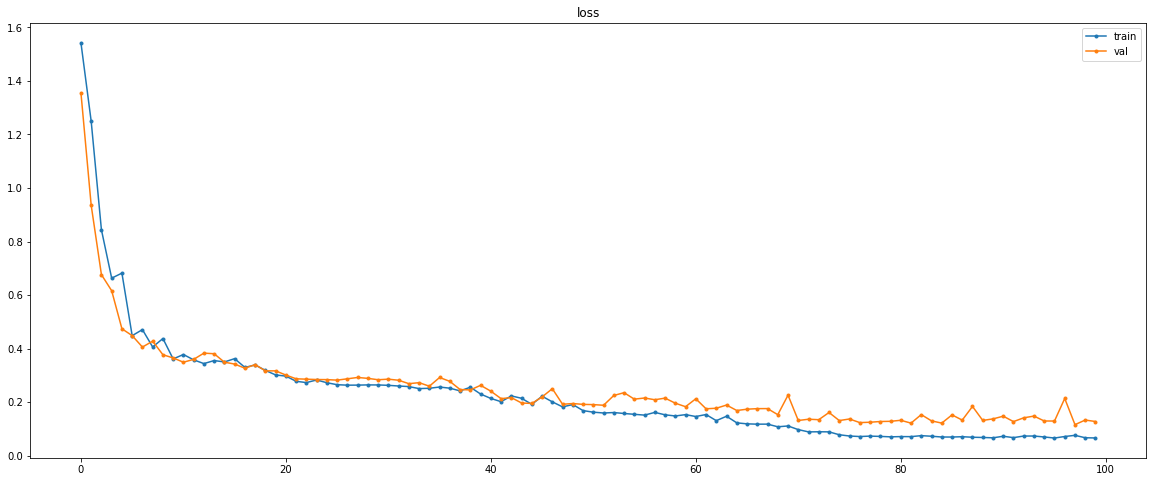

In [162]:
plt.figure(figsize=(20, 8))
plt.title("loss")
plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

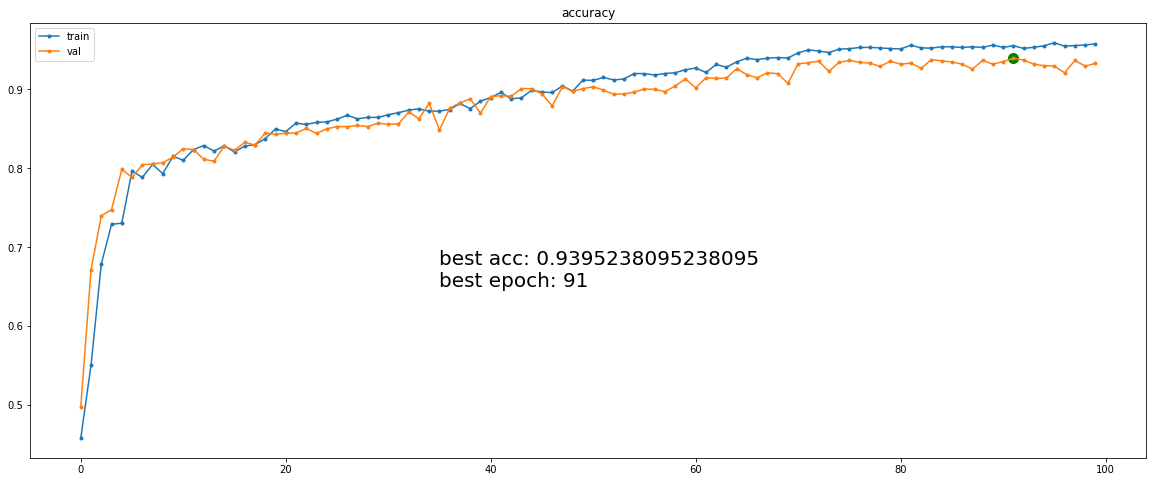

In [68]:
plt.figure(figsize=(20, 8))
plt.title("accuracy")
plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
plt.legend()
plt.show()

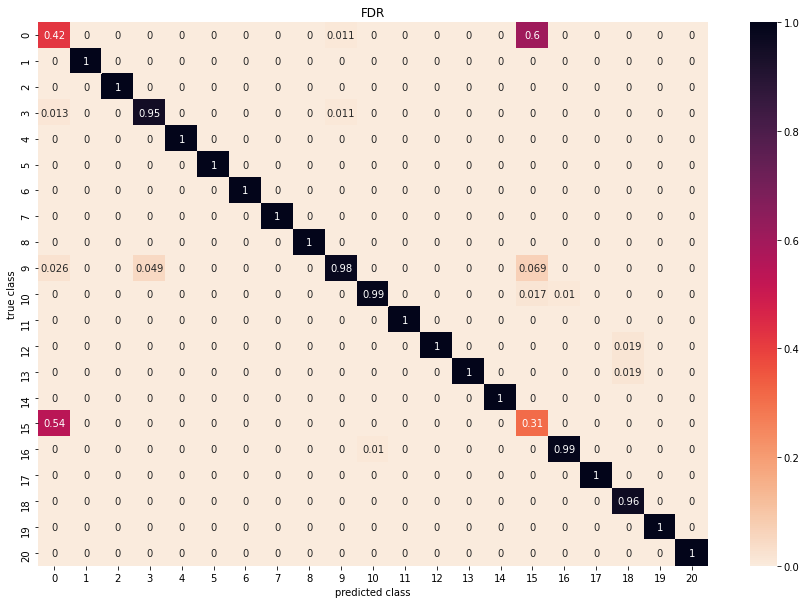

In [76]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

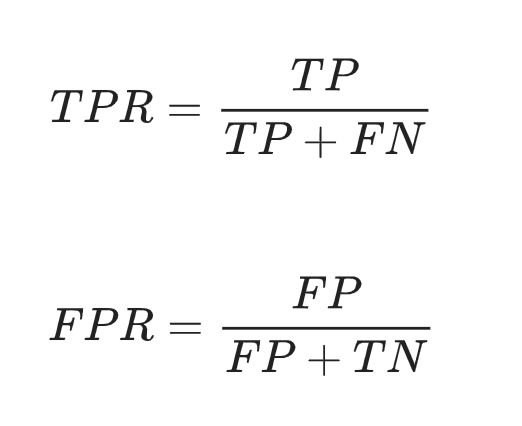

# ----------------------------------------------------------------------------------------

``` python  
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = [1, -1,  0,  0,  1, -1,  1,  0, -1,  0,  1, -1,  1,  0,  0, -1,  0]
y_prediction = [-1, -1,  1,  0,  0,  0,  0, -1,  1, -1,  1,  1,  0,  0,  1,  1, -1]
cnf_matrix = confusion_matrix(y_true, y_prediction)
print(cnf_matrix)
#[[1 1 3]
# [3 2 2]
# [1 3 1]]

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
```

Screenshot 2020-05-11 at 16.30.53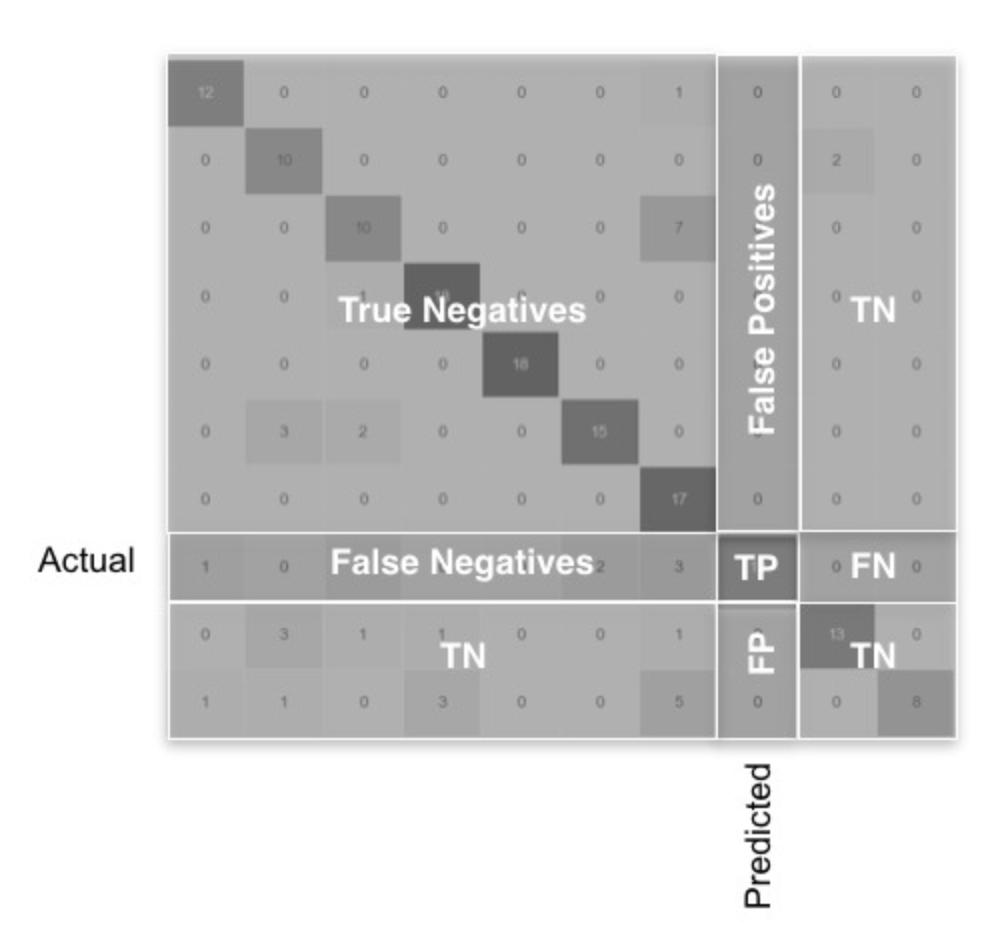

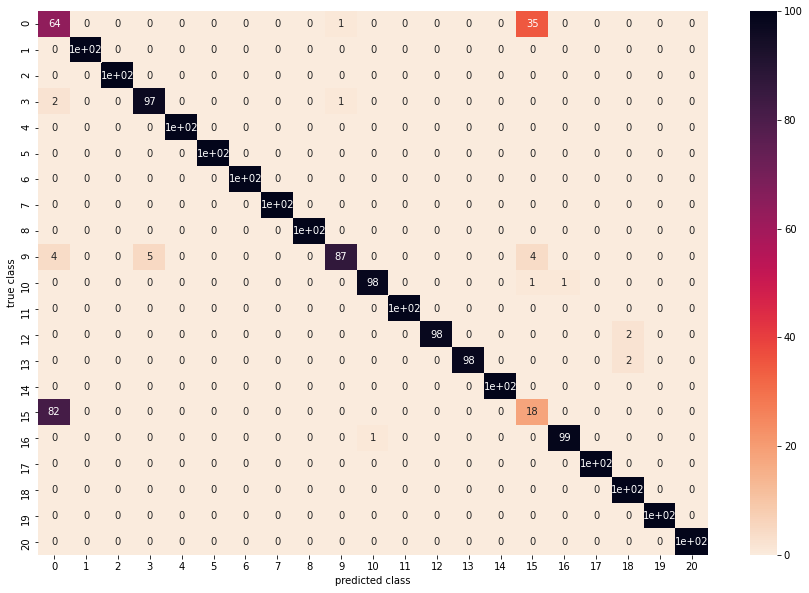

In [78]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true_val, y_ans_val), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [82]:
conf = confusion_matrix(y_true_val, y_ans_val)

In [87]:
FP = conf.sum(axis=0) - np.diag(conf)
FN = conf.sum(axis=1) - np.diag(conf)
TP = np.diag(conf)
TN = conf.sum() - (FP + FN + TP)

In [90]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

ACCURACY = (TP + TN) / (TP + TN + FP + FN)

In [157]:
def plotting(arr, name):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    colors = plt.cm.RdYlGn(norm(arr))

    plt.figure(figsize=(10, 8))
    plt.title(f'{name} per class')
    sns.barplot(x=classes, y=arr, palette=colors)
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.show()

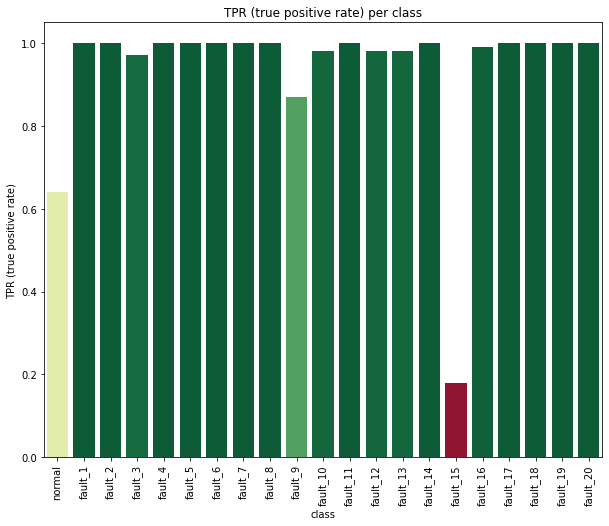

In [158]:
plotting(TPR, "TPR (true positive rate)")

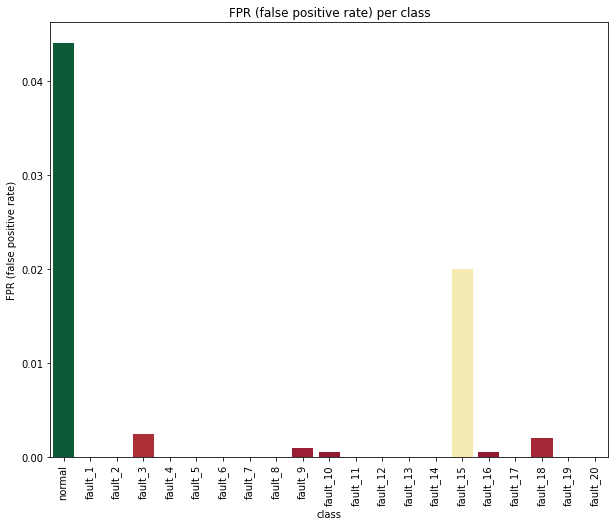

In [159]:
plotting(FPR, "FPR (false positive rate)")

In [161]:
ACCURACY

array([0.94095238, 1.        , 1.        , 0.99619048, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99285714,
       0.99857143, 1.        , 0.99904762, 0.99904762, 1.        ,
       0.94190476, 0.99904762, 1.        , 0.99809524, 1.        ,
       1.        ])

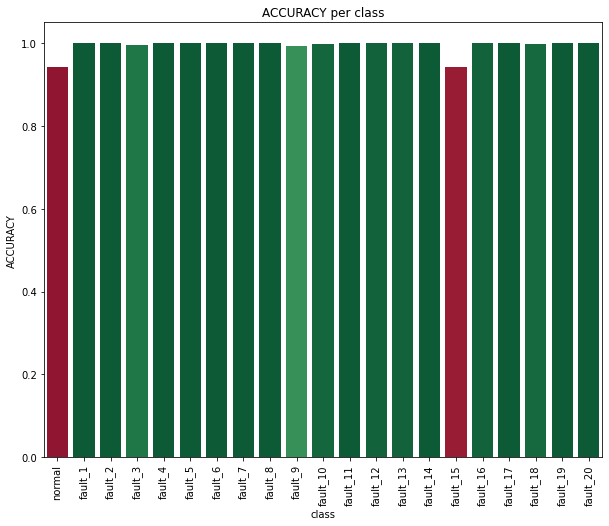

In [160]:
plotting(ACCURACY, "ACCURACY")